# Assignment 1

Discussion Notes:
* Whiskey vs Non-Whiskey (Classification) to be used
* 400K dataset to be used  

Next steps:
* Clean up business understanding
* jeff to put images of barplots of entire dataset within exceptional work
* review/edit write up regarding classification within business rule
* run and clean up code within each section
* add any necessary verbiage for each image

Todo:
* provide a bar chart showing the months represented in the dataset (in visualizations). can include something like sales in the month
* make sure we are answering each quesiton in the rubric in the respective section, so move our outliers discussion and how we addressed them into the data quality section
* provide a few additional visualizations on whiskies
* possibly get a tableau visual of iowa zip codes and whiskies
* do an LDA on whiskey in the exceptional section (dan can work on)

### Business Understanding

Introduction - The Iowa Liquor Sales dataset is an API from Google’s Bigquery which contains the wholesale purchases by retail stores in the Iowa area.  The dataset includes the spirit purchase details by product, date of purchase, and location the item was purchased from an Iowa Class “E” liquor license holder (retail stores) . The timeframe of this data starts from January 1, 2012 through 2019. As part of the study commissioned by the Iowa Department of Commerce, all alcoholic sales within the state were logged into the Department system, and in turn, published as open data by the State of Iowa. The dataset contains detail on the name, product, quantity and location of the individual container or package sale between the wholesaler (vendor) and the retailer.  

1. Set Objectives: We are a new and emerging Whisky brand who specializes in single-malt Rye, and we have targeted the state of Iowa for our next brand expansion. Before doing so, our goal will be to identify and predict which markets are more likely to sell greater volumes of whiskey, so that we can more efficiently spend our marketing dollars and inventory with little waste or buyback. Related questions also include, which brands are going to sell the most in each market, what parts of the year are going to have higher whiskey sales as opposed to lower whiskey sales to optimize advertising dollars, and what features of a town are defining characteristics of a large whiskey seller. 

2. Product Project Plan: To meet our goals, we will first use the Google Bigquery API to access the publicly available Iowa Liquor Sales data via python and Jupyter Notebook. Since the dataset is over 17 million lines of data, we will focus just on 2 months worth of data to do the cleaning. From here, we will define a subset to grant us 30,000 observations, address missing values and begin to build models that could help us answer questions based on markets likely to sell more whiskey. For our data on times of the year when we will sell more whiskey, we will need to create a subset of a full year’s data to build a time series model. For the town features, we will need to include additional information about the zip codes of iowa (such as population, income, ect) to get more demographic detail on each market to assist with a program for a clustering problem. For each of these problems, we will create a training and testing data set to help tune our predictions. 

3. Business Success Criteria - For our prediction models of market sales, we will be consider our model successful if we are able to classify our alochol type with a strong precision, recall and accuracy using a cross validation. Ideally, if we are dealing with 5 alcohol types, we will want to be able to predict whiskey accurately over 20% of the time.  
 * Classification - 'Introduction to Data Mining' book - pages 173 to 196.  Estimating the generalization error of a model during training. The estimated error helps the learning algorithm to do model selection; i.e., to find a model of the right complexity that is not susceptible to over fitting. Once the model bas been constructed, it can be applied to the test set to predict the class labels of previously unseen records. It is often useful to measure the performance of the model on the test set because such a measure provides an unbiased estimate of its generalization error. The accuracy or error rate computed from the test set can also be used to compare the relative performance of different classifiers on the same domain. However, iu order to do tbis, the class labels of the test records must be knowu. This sectiom reviews some of the methods collliilonly used to evaluate the performance of a classifier.
    * Holdout Method In the holdout method, the original data with labeled examples is partitioned into two disjoint sets, called the training and the test sets, respectively. A clasBi£cation model is then indnced from the training set and its performance is evaluated on the test set. The proportion of data reserved for training and for testiug is typically at the discretion of the aualysts (e.g., 50-50 or twothirds for training and one-third for testing}. The accuracy of the classifier can be estimated based on the accuracy of the induced model on the test set. 
     * Other methods that may be used Cross-Validation, Random subsampling, and bootstrap. 
 
 * Regression - From the sale price prediction problem, we will run a linear regression technique against the remaining features. For this technique, we will use Root Mean Square Error to evaluate the effectiveness. A strong criteria for performance would be if we can get within $3 as an RMSE. ?? Should we also use R-squared is a relative measure of fit and OLS? Look at 6371 Unit 9 through 11. Lack of fit tests, scatterplot of residual, studentized residuals and other fit diagnostics. 
 


## Data Meaning Type

The initial data set is 4.63GB with 17.7 million rows.  This was too large for our systems to handle, so we took a subset of the data.  Please refer to the Exception Work on how we analyzed the full data set, which included a combination of BigQuery queries, and visualizing that data in order to come up with our subset which we saved as a csv file in our github repository

### Load Python Packages

In [0]:
# Import necessary python packages
try:
    from collections import abc as collections_abc
except ImportError:  # Python 2.7
    import collections as collections_abc

    import copy
import functools
import gzip
import io
import itertools
import json
import math
import os
import tempfile
import uuid
import warnings
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd
import numpy as np
#import altair as alt
import matplotlib.pyplot as plt
import re

# Imports the Google Cloud client library
#from google.cloud import storage
from google.oauth2 import service_account
from google.cloud import bigquery

### Load Data from github

For our measurement, we will be querying the 2019 and limiting the rows to 
50,000 for our intial modeling, which we can later expand to see how our model translates to scale.

In [240]:
# Read csv from disk
#df =  pd.read_csv(r'/Users/jjschued/Documents/Github/7331DataMiningNotebooks/lab1/iowa_subset_2019_400k_random_rows.csv', nrows = 100000)
#df =  pd.read_csv(r'/Users/danielclark/Desktop/SMU/data_mining/7331DataMiningNotebooks/lab1/iowa_subset_2019_400k_random_rows.csv', nrows = 50000)

# read csv from github directly
url_dataset = 'https://github.com/jjschueder/7331DataMiningNotebooks/blob/master/lab1/iowa_subset_2019_400k_random_rows.csv?raw=true'
df = pd.read_csv(url_dataset, nrows=100000)

# verify data read in
print(df.head(5))

  invoice_and_item_number        date  store_number  \
0         INV-23084400002  2019-11-07          3869   
1         INV-23282200001  2019-11-18          4617   
2         INV-19435800130  2019-05-17          2560   
3         INV-23454200002  2019-11-25          2614   
4         INV-23541200001  2019-11-27          2629   

                               store_name                     address  \
0               Bootleggin' Barzini's Fin                412  1st Ave   
1                          Lickety Liquor            2501 HUBBELL AVE   
2              Hy-Vee Food Store / Marion  3600 Business Hwy 151 East   
3  Hy-Vee #3 Food & Drugstore / Davenport          1823 E Kimberly Rd   
4   Hy-Vee Food Store #2 / Council Bluffs            1745 Madison Ave   

             city  zip_code                        store_location  \
0      Coralville   52241.0          POINT (-91.565517 41.672672)   
1      Des Moines   50317.0          POINT (-93.570489 41.607817)   
2          Marion   523

### Columns and Descriptions

Below are the 24 columns found in the data set along with description of each 

In [241]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 24 columns):
invoice_and_item_number    100000 non-null object
date                       100000 non-null object
store_number               100000 non-null int64
store_name                 100000 non-null object
address                    99819 non-null object
city                       99819 non-null object
zip_code                   99819 non-null float64
store_location             90414 non-null object
county_number              99819 non-null float64
county                     99819 non-null object
category                   99696 non-null float64
category_name              99696 non-null object
vendor_number              100000 non-null int64
vendor_name                100000 non-null object
item_number                100000 non-null int64
item_description           100000 non-null object
pack                       100000 non-null int64
bottle_volume_ml           100000 non-null int64


Detailed Description of each field - referenced from the [data.iowa.gov](https://data.iowa.gov/Sales-Distribution/Iowa-Liquor-Sales/m3tr-qhgy) site that describes the dataset

*   invoice_and_item_number (text) - Invoice and item associated with the liquor order.  This is unique identifier 
*   date (date) - Date of when the order was placed
*   store_number (int) - Unique number assigned to the retail store that placed the order
*   store_name (text) - Name of the retail store that placed the order
*   address (text) - Address of the retail store that placed the order
*   city (text) - City of the retail store that placed the order
*   zip_code (float) - Zip code of the retail store that placed the order
*   store_location (text) - Lat/Long of retail store that placed the order
*   county_number (float) - Iowa county number for which the retail store that placed the order resides
*   county (text) - County name for which the retail store is located that placed the order
*   category (float) - Category code for the liquor that was ordered
*   category_name (text) - Category of the liquor that was ordered
*   vendor_number (int) - The vendor number of the company for the brand of liquor ordered 
*   vendor_name (text) - The vendor name of the company for the brand of liquor ordered
*   item_number (int) - Item number for individual liquor product ordered
*   item_description (text) - Description of the liquor item ordered
*   pack (int) - The number of bottles in a case for the liquor ordered
*   bottle_volume_ml (int) - Volume of each liquor bottle ordered in milliliters
*   state_bottle_cost (float) - The amount that Alcoholic Beverages Division paid for each bottle of liquor ordered
*   state_bottle_retail (float) - The amount the store paid for each bottle of liquor ordered
*   bottles_sold (int) - Number of bottles of liquor ordered by the retail store
*   sale_dollars (float) - Total cost of liquor ordered (bottles_sold * state_bottle_retail)
*   volume_sold_liters (float) - Total volume of liquor ordered in liters (bottle_volume_ml * bottles_sold / 1000)
*   volume_sold_gallons (float) - Total volume of liquor ordered in gallons (bottle_volume_ml * bottles_sold / 3785.411784)





## Data Quality  
Verify data quality: Explain any missing values, duplicate data, and outliers. Are those mistakes? How do you deal with these problems? Give justifications for your methods.

In [242]:
df.info

<bound method DataFrame.info of       invoice_and_item_number        date  store_number  \
0             INV-23084400002  2019-11-07          3869   
1             INV-23282200001  2019-11-18          4617   
2             INV-19435800130  2019-05-17          2560   
3             INV-23454200002  2019-11-25          2614   
4             INV-23541200001  2019-11-27          2629   
...                       ...         ...           ...   
99995         INV-22219300036  2019-09-30          3776   
99996         INV-22567100020  2019-10-15          5351   
99997         INV-22471800013  2019-10-11          2607   
99998         INV-22549300142  2019-10-15          2651   
99999         INV-22741000016  2019-10-23          3773   

                                   store_name                     address  \
0                   Bootleggin' Barzini's Fin                412  1st Ave   
1                              Lickety Liquor            2501 HUBBELL AVE   
2                  Hy-Vee Fo

Running a df.columns.values function, confirms the 24 features that we referenced in our Data understanding phase. This now allows us to move forward with our data cleaning. 

In [243]:
df.columns.values

array(['invoice_and_item_number', 'date', 'store_number', 'store_name',
       'address', 'city', 'zip_code', 'store_location', 'county_number',
       'county', 'category', 'category_name', 'vendor_number',
       'vendor_name', 'item_number', 'item_description', 'pack',
       'bottle_volume_ml', 'state_bottle_cost', 'state_bottle_retail',
       'bottles_sold', 'sale_dollars', 'volume_sold_liters',
       'volume_sold_gallons'], dtype=object)

### Data Cleaning

In our data cleaning step, we need to perform a few specific data cleaning operations to:
1.   Convert our features to the correct continuous, ordinal and categorical features
> Replace the values for pack, bottle_volume_ml, store_number, store_name, address, city, zip_code, county_number, county, category, category_name, vendor_number, vendor_name, item_number and item_description into categorical variables so they register as a non-null object in our model

2.   Address the missing values
> Replace all "?", which our dataset denotes as null, into "-1" values (not strings). From here, we will convert state_bottle_cost, state_bottle_retail, sale_dollars, volume_sold_liters, and volume_sold_gallons into continuous variables so they register as floats.

3.   Create a category that simplifies our alcohol categories to specific genres like whiskey, vodka, tequilla, ect.
4.   Categorize our store locations into a few easily discernable buckets
5.   Create a month and date column for opportunities to time and date analysis
6.   Convert the varaible "bottles_sold" into ordinal features so they register as an integer value in our models  

Using a df.types function helps to verify this. 

In [244]:
df.dtypes

invoice_and_item_number     object
date                        object
store_number                 int64
store_name                  object
address                     object
city                        object
zip_code                   float64
store_location              object
county_number              float64
county                      object
category                   float64
category_name               object
vendor_number                int64
vendor_name                 object
item_number                  int64
item_description            object
pack                         int64
bottle_volume_ml             int64
state_bottle_cost          float64
state_bottle_retail        float64
bottles_sold                 int64
sale_dollars               float64
volume_sold_liters         float64
volume_sold_gallons        float64
dtype: object

The following will do some cleanup on values and categorize store, category, and dates into more summarized values

In [245]:
#upper case category name for matching later
df['category_name'] = df['category_name'].str.upper()

df['category_name'][40:45]

40    TEMPORARY & SPECIALTY PACKAGES
41    TEMPORARY & SPECIALTY PACKAGES
42                        TRIPLE SEC
43                 IMPORTED DRY GINS
44                 IMPORTED DRY GINS
Name: category_name, dtype: object

In [246]:
#upper case category name for matching later
df['item_description'] = df['item_description'].str.upper()

df['item_description'][40:45]

40               EVAN WILLIAMS EGG NOG
41    SMIRNOFF RED, WHITE & BERRY MINI
42                   JUAREZ TRIPLE SEC
43                       BEEFEATER GIN
44                       TANQUERAY GIN
Name: item_description, dtype: object

In [0]:
#convert nan to blanks
df = (df.replace(r'^\s*$', np.nan, regex=True))
df = (df.replace(np.nan, 'blank', regex=True))

In [0]:
#Start with everything going into Other, and then look for keyword to put into specific category
df['liquor_category'] = 'Other'
df.loc[df['category_name'].str.contains('GINS'), 'liquor_category'] = 'GIN'
df.loc[df['category_name'].str.contains('GINS'), 'liquor_category'] = 'GIN'
df.loc[df['category_name'].str.contains('GIN'), 'liquor_category'] = 'GIN'
df.loc[df['category_name'].str.contains('RUMS'), 'liquor_category'] = 'RUM'
df.loc[df['category_name'].str.contains('RUM'), 'liquor_category'] = 'RUM'
df.loc[df['category_name'].str.contains('SCOTCH'), 'liquor_category'] = 'WHISKY'
df.loc[df['category_name'].str.contains('WHISKIES'), 'liquor_category'] = 'WHISKY'
df.loc[df['category_name'].str.contains('WHISKY'), 'liquor_category'] = 'WHISKY'
df.loc[df['category_name'].str.contains('WHISKEY'), 'liquor_category'] = 'WHISKY'
df.loc[df['category_name'].str.contains('RYE'), 'liquor_category'] = 'WHISKY'
df.loc[df['category_name'].str.contains('AMARETTO'), 'liquor_category'] = 'AMARETTO'
df.loc[df['category_name'].str.contains('BOURBON'), 'liquor_category'] = 'WHISKY'
df.loc[df['category_name'].str.contains('LIQUEURS'), 'liquor_category'] = 'LIQUEUR'
df.loc[df['category_name'].str.contains('LIQUEUR'), 'liquor_category'] = 'LIQUEUR'
df.loc[df['category_name'].str.contains('VODKAS'), 'liquor_category'] = 'VODKA'
df.loc[df['category_name'].str.contains('VODKA'), 'liquor_category'] = 'VODKA'
df.loc[df['category_name'].str.contains('BRANDY'), 'liquor_category'] = 'BRANDY'
df.loc[df['category_name'].str.contains('BRANDIES'), 'liquor_category'] = 'GIN'
df.loc[df['category_name'].str.contains('CREME'), 'liquor_category'] = 'SCHNAPPS'
df.loc[df['category_name'].str.contains('SCHNAPPS'), 'liquor_category'] = 'SCHNAPPS'
df.loc[df['category_name'].str.contains('TEQUILA'), 'liquor_category'] = 'TEQUILA'
df.loc[df['category_name'].str.contains('TEQUILAS'), 'liquor_category'] = 'TEQUILA'



#get a few stray not available categories per internet this is tequila
df.loc[df['item_description'] == 'Herradura Gold Reposado 6pak', 'liquor_category'] = "Tequila"
df.loc[df['item_description'] == 'Chambord Liqueur w/2 Glasses', 'liquor_category'] = "Liquers"



In [0]:
#get some others by going to item description and doing same translation as above
df.loc[df['liquor_category'].str.contains('Other') & df['item_description'].str.contains('GINS'), 'liquor_category'] = 'GIN'
df.loc[df['liquor_category'].str.contains('Other') & df['item_description'].str.contains('GINS'), 'liquor_category'] = 'GIN'
df.loc[df['liquor_category'].str.contains('Other') & df['item_description'].str.contains('GIN'), 'liquor_category'] = 'GIN'
df.loc[df['liquor_category'].str.contains('Other') & df['item_description'].str.contains('RUMS'), 'liquor_category'] = 'RUM'
df.loc[df['liquor_category'].str.contains('Other') & df['item_description'].str.contains('RUM'), 'liquor_category'] = 'RUM'
df.loc[df['liquor_category'].str.contains('Other') & df['item_description'].str.contains('SCOTCH'), 'liquor_category'] = 'WHISKY'
df.loc[df['liquor_category'].str.contains('Other') & df['item_description'].str.contains('WHISKIES'), 'liquor_category'] = 'WHISKY'
df.loc[df['liquor_category'].str.contains('Other') & df['item_description'].str.contains('WHISKY'), 'liquor_category'] = 'WHISKY'
df.loc[df['liquor_category'].str.contains('Other') & df['item_description'].str.contains('WHISKEY'), 'liquor_category'] = 'WHISKY'
df.loc[df['liquor_category'].str.contains('Other') & df['item_description'].str.contains('RYE'), 'liquor_category'] = 'WHISKY'
df.loc[df['liquor_category'].str.contains('Other') & df['item_description'].str.contains('AMARETTO'), 'liquor_category'] = 'AMARETTO'
df.loc[df['liquor_category'].str.contains('Other') & df['item_description'].str.contains('BOURBON'), 'liquor_category'] = 'WHISKY'
df.loc[df['liquor_category'].str.contains('Other') & df['item_description'].str.contains('LIQUEURS'), 'liquor_category'] = 'LIQUEUR'
df.loc[df['liquor_category'].str.contains('Other') & df['item_description'].str.contains('LIQUEUR'), 'liquor_category'] = 'LIQUEUR'
df.loc[df['liquor_category'].str.contains('Other') & df['item_description'].str.contains('VODKAS'), 'liquor_category'] = 'VODKA'
df.loc[df['liquor_category'].str.contains('Other') & df['item_description'].str.contains('VODKA'), 'liquor_category'] = 'VODKA'
df.loc[df['liquor_category'].str.contains('Other') & df['item_description'].str.contains('BRANDY'), 'liquor_category'] = 'BRANDY'
df.loc[df['liquor_category'].str.contains('Other') & df['item_description'].str.contains('BRANDIES'), 'liquor_category'] = 'GIN'
df.loc[df['liquor_category'].str.contains('Other') & df['item_description'].str.contains('CREME'), 'liquor_category'] = 'SCHNAPPS'
df.loc[df['liquor_category'].str.contains('Other') & df['item_description'].str.contains('SCHNAPPS'), 'liquor_category'] = 'SCHNAPPS'
df.loc[df['liquor_category'].str.contains('Other') & df['item_description'].str.contains('TEQUILA'), 'liquor_category'] = 'TEQUILA'
df.loc[df['liquor_category'].str.contains('Other') & df['item_description'].str.contains('TEQUILAS'), 'liquor_category'] = 'TEQUILA'
df.loc[df['liquor_category'].str.contains('Other') & df['item_description'].str.contains('JOSE'), 'liquor_category'] = 'TEQUILA'
df.loc[df['liquor_category'].str.contains('Other') & df['item_description'].str.contains('PATRON'), 'liquor_category'] = 'TEQUILA'
df.loc[df['liquor_category'].str.contains('Other') & df['item_description'].str.contains('JAMESON'), 'liquor_category'] = 'WHISKY'
df.loc[df['liquor_category'].str.contains('Other') & df['item_description'].str.contains('CROWN'), 'liquor_category'] = 'WHISKY'
df.loc[df['liquor_category'].str.contains('Other') & df['item_description'].str.contains('BEAM'), 'liquor_category'] = 'WHISKY'
df.loc[df['liquor_category'].str.contains('Other') & df['item_description'].str.contains('DANIELS'), 'liquor_category'] = 'WHISKY'
df.loc[df['liquor_category'].str.contains('Other') & df['item_description'].str.contains('MORGAN'), 'liquor_category'] = 'RUM'
df.loc[df['liquor_category'].str.contains('Other') & df['item_description'].str.contains('JOHNNIE WALKER'), 'liquor_category'] = 'WHISKY'
df.loc[df['liquor_category'].str.contains('Other') & df['item_description'].str.contains('GENTLEMAN'), 'liquor_category'] = 'WHISKY'
df.loc[df['liquor_category'].str.contains('Other') & df['item_description'].str.contains('1800'), 'liquor_category'] = 'TEQUILA'
df.loc[df['liquor_category'].str.contains('Other') & df['item_description'].str.contains('BUSHMIL'), 'liquor_category'] = 'WHISKY'
df.loc[df['liquor_category'].str.contains('Other') & df['item_description'].str.contains('KNOB'), 'liquor_category'] = 'WHISKY'
df.loc[df['liquor_category'].str.contains('Other') & df['item_description'].str.contains('TORTILLA'), 'liquor_category'] = 'TEQUILA'
df.loc[df['liquor_category'].str.contains('Other') & df['item_description'].str.contains('GOOSE'), 'liquor_category'] = 'VODKA'
df.loc[df['liquor_category'].str.contains('Other') & df['item_description'].str.contains('MARGARITA'), 'liquor_category'] = 'TEQUILA'
df.loc[df['liquor_category'].str.contains('Other') & df['item_description'].str.contains('TRIPLE SEC'), 'liquor_category'] = 'LIQUEUR'

In [250]:
#upper case category name for matching later
df['store_name'] = df['store_name'].str.upper()

df['store_name'][40:45]

40    HY-VEE FOOD STORE / CHARITON
41       HY-VEE DRUGSTORE #2 / WDM
42                  CENTRAL CITY 2
43      HY-VEE FOOD STORE / MARION
44                 CYCLONE LIQUORS
Name: store_name, dtype: object

In [0]:
#grouping all the store locations into parent stores
df['store_parent'] = 'Other'
df.loc[df['store_name'].str.contains('HY-VEE'), 'store_parent'] = 'Hy-Vee'
df.loc[df['store_name'].str.contains('WAL-MART'), 'store_parent'] = 'Wal-Mart'
df.loc[df['store_name'].str.contains('SAM'), 'store_parent'] = 'SamsClub'
df.loc[df['store_name'].str.contains('Fareway'), 'store_parent'] = 'Fareway'
df.loc[df['store_name'].str.contains('KUM'), 'store_parent'] = 'Kum&Go'
df.loc[df['store_name'].str.contains('CVS'), 'store_parent'] = 'CVS'
df.loc[df['store_name'].str.contains('TARGET'), 'store_parent'] = 'Target'
df.loc[df['store_name'].str.contains('CASEY'), 'store_parent'] = 'Caseys'
df.loc[df['store_name'].str.contains('DAHL'), 'store_parent'] = 'Dahls'
df.loc[df['store_name'].str.contains('QUIK'), 'store_parent'] = 'QuikTrip'
df.loc[df['store_name'].str.contains('WALGREEN'), 'store_parent'] = 'Walgreens'
df.loc[df['store_name'].str.contains('SMOKIN'), 'store_parent'] = 'SmokingJoes'
#labored conversion of dates to month year and month year by converting to strings
df['month'] = pd.DatetimeIndex(df['date']).month
df['year'] = pd.DatetimeIndex(df['date']).year

df.loc[df['month'] ==1 , 'month'] = 'Jan'
df.loc[df['month'] ==2 , 'month'] = 'Feb'
df.loc[df['month'] ==3 , 'month'] = 'Mar'
df.loc[df['month'] ==4 , 'month'] = 'Apr'
df.loc[df['month'] ==5 , 'month'] = 'May'
df.loc[df['month'] ==6 , 'month'] = 'Jun'
df.loc[df['month'] ==7 , 'month'] = 'Jul'
df.loc[df['month'] ==8 , 'month'] = 'Aug'
df.loc[df['month'] ==9 , 'month'] = 'Sep'
df.loc[df['month'] ==10 , 'month'] = 'Oct'
df.loc[df['month'] ==11 , 'month'] = 'Nov'
df.loc[df['month'] ==12 , 'month'] = 'Dec'


df.loc[df['year'] ==2012 , 'year'] = '2012'
df.loc[df['year'] ==2013 , 'year'] = '2013'
df.loc[df['year'] ==2014 , 'year'] = '2014'
df.loc[df['year'] ==2015 , 'year'] = '2015'
df.loc[df['year'] ==2016 , 'year'] = '2016'
df.loc[df['year'] ==2017 , 'year'] = '2017'
df.loc[df['year'] ==2018 , 'year'] = '2018'
df.loc[df['year'] ==2019 , 'year'] = '2019'

#merge year and month together
df['monthyear'] = df['month'] + "-" + df['year']

In [252]:
df.head(20)

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,category,category_name,vendor_number,vendor_name,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,liquor_category,store_parent,month,year,monthyear
0,INV-23084400002,2019-11-07,3869,BOOTLEGGIN' BARZINI'S FIN,412 1st Ave,Coralville,52241,POINT (-91.565517 41.672672),52,JOHNSON,1.0921e+06,IMPORTED DISTILLED SPIRIT SPECIALTY,293,JINRO AMERICA INC,989215,JINRO CHAMISUL GRAPEFRUIT SOJU,20,375,3.85,5.78,20,115.60,7.50,1.98,Other,Other,Nov,2019,Nov-2019
1,INV-23282200001,2019-11-18,4617,LICKETY LIQUOR,2501 HUBBELL AVE,Des Moines,50317,POINT (-93.570489 41.607817),77,POLK,1.0913e+06,NEUTRAL GRAIN SPIRITS FLAVORED,346,OLE SMOKY DISTILLERY LLC,86739,OLE SMOKY APPLE PIE MOONSHINE 70PRF MINI,8,50,8.75,13.13,1,13.13,0.05,0.01,Other,Other,Nov,2019,Nov-2019
2,INV-19435800130,2019-05-17,2560,HY-VEE FOOD STORE / MARION,3600 Business Hwy 151 East,Marion,52302,blank,57,LINN,1.0421e+06,IMPORTED DRY GINS,35,BACARDI USA INC,28233,BOMBAY SAPPHIRE GIN,12,1000,16.50,24.75,6,148.50,6.00,1.58,GIN,Hy-Vee,May,2019,May-2019
3,INV-23454200002,2019-11-25,2614,HY-VEE #3 FOOD & DRUGSTORE / DAVENPORT,1823 E Kimberly Rd,Davenport,52807,POINT (-90.548919 41.55678100000001),82,SCOTT,1.0113e+06,SINGLE BARREL BOURBON WHISKIES,184,FOUR ROSES DISTILLERY,18350,FOUR ROSES SINGLE BARREL,6,750,21.17,31.76,24,762.24,18.00,4.75,WHISKY,Hy-Vee,Nov,2019,Nov-2019
4,INV-23541200001,2019-11-27,2629,HY-VEE FOOD STORE #2 / COUNCIL BLUFFS,1745 Madison Ave,Council Bluffs,51503,POINT (-95.825137 41.242732),78,POTTAWATTA,1.9012e+06,SPECIAL ORDER ITEMS,285,Charles Jacquin Et Cie,902291,SOOH BARTENDERS BANANAS OVER YOU,6,1750,9.31,13.97,12,167.64,21.00,5.54,Other,Hy-Vee,Nov,2019,Nov-2019
5,INV-23540300028,2019-11-27,4312,I-80 LIQUOR / COUNCIL BLUFFS,2411 S 24TH ST #1,Council Bluffs,51501,POINT (-95.8792 41.238092),78,POTTAWATTA,1.0123e+06,SINGLE MALT SCOTCH,370,PERNOD RICARD USA,5037,GLENLIVET 12YR,12,1000,28.98,43.47,6,260.82,6.00,1.58,WHISKY,Other,Nov,2019,Nov-2019
6,INV-19655400089,2019-05-29,2517,HY-VEE FOOD STORE #1 / NEWTON,1501 First Avenue East,Newton,50208,POINT (-93.034296 41.69916),50,JASPER,1.7011e+06,TEMPORARY & SPECIALTY PACKAGES,260,DIAGEO AMERICAS,77955,"SMIRNOFF RED, WHITE & BERRY MINI",12,500,4.90,7.35,12,88.20,6.00,1.58,Other,Hy-Vee,May,2019,May-2019
7,INV-23687700099,2019-12-05,2545,HY-VEE DRUGSTORE / IOWA CITY,310 N 1st St,Iowa City,52245,POINT (-91.528105 42.207428),52,JOHNSON,1.7011e+06,TEMPORARY & SPECIALTY PACKAGES,259,Heaven Hill Brands,64489,CAROLANS SALTED CARAMEL,6,750,8.50,12.75,30,382.50,22.50,5.94,Other,Hy-Vee,Dec,2019,Dec-2019
8,INV-17141800065,2019-01-25,5210,DING'S HONK'N HOLLER,"900, E Washington St",Clarinda,51632,POINT (-95.027238 40.739231),73,PAGE,1.0913e+06,NEUTRAL GRAIN SPIRITS FLAVORED,346,OLE SMOKY DISTILLERY LLC,86739,OLE SMOKY APPLE PIE MOONSHINE 70PRF MINI,8,300,8.75,13.13,2,26.26,0.60,0.15,Other,Other,Jan,2019,Jan-2019
9,INV-23109300014,2019-11-08,5411,BLUEJAY MARKET,2810 Wills Ave,Perry,50220,POINT (-94.081127 41.838488),25,DALLAS,1.7011e+06,TEMPORARY & SPECIALTY PACKAGES,410,Patron Spirits Company,100258,PATRON SILVER VERSION 4.0,6,1000,33.34,50.01,6,300.06,6.00,1.58,TEQUILA,Other,Nov,2019,Nov-2019


In [0]:
# Write df to csv

# Write to disk - absolute path
#df.to_csv(r'/Users/jjschued/Documents/Github/otheralcoholanalysis.csv')

# Write to disk - relative path
df.to_csv(r'./otheralcoholanalysis.csv')

At the far right of the above dataset, you can see the 5 new columns we created and thier respective values. 

In [254]:
import numpy as np
# replace '?' with -1, we will deal with missing values later
df = df.replace(to_replace='?',value=-1) 

categorical_features = ['city', 'county',  'category_name','vendor_name', 'store_number', 'item_description','store_parent', 
                        'monthyear', 'liquor_category', 'county_number', 'vendor_number', 'item_number']

# let's start by first changing the numeric values to be floats
continuous_features = ['state_bottle_cost', 'state_bottle_retail', 'sale_dollars', 'volume_sold_liters', 'volume_sold_gallons', 'bottles_sold']

# and the oridnal values to be integers
ordinal_features = ['pack', 'bottle_volume_ml']

# use the "astype" function to change the variable type
df[continuous_features] = df[continuous_features].astype(np.float64)
df[ordinal_features] = df[ordinal_features].astype(np.int64)
df[categorical_features] = df[categorical_features].astype(object)
df.info() # now our data looks better!!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 29 columns):
invoice_and_item_number    100000 non-null object
date                       100000 non-null object
store_number               100000 non-null object
store_name                 100000 non-null object
address                    100000 non-null object
city                       100000 non-null object
zip_code                   100000 non-null object
store_location             100000 non-null object
county_number              100000 non-null object
county                     100000 non-null object
category                   100000 non-null object
category_name              100000 non-null object
vendor_number              100000 non-null object
vendor_name                100000 non-null object
item_number                100000 non-null object
item_description           100000 non-null object
pack                       100000 non-null int64
bottle_volume_ml           100000 non-nul

In [255]:
# will get summary of continuous or the nominals
dfstats = df.describe()

# let's set those values to NaN, so that Pandas understand they are missing
df = df.replace(to_replace=-1,value=np.nan) # replace -1 with NaN (not a number)
#print (df.info())
df[categorical_features] = df[categorical_features].astype(object)
dfstats2 = df.describe() # scroll over to see the values

categorical_features = ['city', 'county',  'category_name','vendor_name', 'store_number', 'item_description','store_parent', 
                        'monthyear', 'liquor_category', 'county_number', 'vendor_number', 'item_number']

# let's start by first changing the numeric values to be floats
continuous_features = ['state_bottle_cost', 'state_bottle_retail', 'sale_dollars', 'volume_sold_liters', 'volume_sold_gallons', 'bottles_sold']

# and the oridnal values to be integers
ordinal_features = ['pack', 'bottle_volume_ml']

# use the "astype" function to change the variable type
df[continuous_features] = df[continuous_features].astype(np.float64)
df[ordinal_features] = df[ordinal_features].astype(np.int64)
df[categorical_features] = df[categorical_features].astype(object)
df['store_number'] = df['store_number'].astype(object)
df.info() # now our data looks better!!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 29 columns):
invoice_and_item_number    100000 non-null object
date                       100000 non-null object
store_number               100000 non-null object
store_name                 100000 non-null object
address                    100000 non-null object
city                       100000 non-null object
zip_code                   100000 non-null object
store_location             100000 non-null object
county_number              100000 non-null object
county                     100000 non-null object
category                   100000 non-null object
category_name              100000 non-null object
vendor_number              100000 non-null object
vendor_name                100000 non-null object
item_number                100000 non-null object
item_description           100000 non-null object
pack                       100000 non-null int64
bottle_volume_ml           100000 non-nul

Here, you can see that our cleaning has addressed all nulls down to zero so we can begin analysis. The count code below helps to show that there is zero nulls in our dataset.

In [256]:
dfna = df[df.isna().any(axis=1)]
dfna.isna().sum()

invoice_and_item_number    0
date                       0
store_number               0
store_name                 0
address                    0
city                       0
zip_code                   0
store_location             0
county_number              0
county                     0
category                   0
category_name              0
vendor_number              0
vendor_name                0
item_number                0
item_description           0
pack                       0
bottle_volume_ml           0
state_bottle_cost          0
state_bottle_retail        0
bottles_sold               0
sale_dollars               0
volume_sold_liters         0
volume_sold_gallons        0
liquor_category            0
store_parent               0
month                      0
year                       0
monthyear                  0
dtype: int64

The next task will be for us to look into our categorical features with over 30 unique values, and we will be dropping any columns that have more than 30 uniques. The reason we are doing this is that we will ultimately have trouble with our predictions as these values will likely ultimately have unique attributes to a specific combination of observations. 

In [257]:
#Unique Value Threshold (Per Column)
#Delete Columns >  uniqueThreshold unique values prior to one-hot encoding. 
#(each unique value becomes a new column during one-hot encoding)
uniqueThreshold = 30
# in each column of dataframe
uniqueValues = df.nunique()
uniqueValues

invoice_and_item_number    100000
date                          264
store_number                 1707
store_name                   1715
address                      1709
city                          425
zip_code                      458
store_location               1577
county_number                 100
county                        129
category                       40
category_name                  40
vendor_number                 122
vendor_name                   123
item_number                  1322
item_description             1284
pack                           15
bottle_volume_ml               23
state_bottle_cost             712
state_bottle_retail           712
bottles_sold                  120
sale_dollars                 4051
volume_sold_liters            257
volume_sold_gallons           256
liquor_category                10
store_parent                   11
month                          12
year                            1
monthyear                      12
dtype: int64

In [258]:
#Isolate continuous and categorical data types
#These are indexers into the schoolData dataframe and may be used similar to the schoolData dataframe 
D_boolean = df.loc[:, (df.dtypes == bool) ]
D_nominal = df.loc[:, (df.dtypes == object)]
D_continuous = df.loc[:, (df.dtypes != bool) & (df.dtypes != object)]
print ("Boolean Columns: ", D_boolean.shape[1])
print ("Nominal Columns: ", D_nominal.shape[1])
print ("Continuous Columns: ", D_continuous.shape[1])
print ("Columns Accounted for: ", D_nominal.shape[1] + D_continuous.shape[1] + D_boolean.shape[1])

Boolean Columns:  0
Nominal Columns:  21
Continuous Columns:  8
Columns Accounted for:  29


In [0]:
#Delete categorical columns with > 30 unique values (Each unique value becomes a column during one-hot encoding)
oneHotUniqueValueCounts = df[D_nominal.columns].apply(lambda x: x.nunique())
oneHotUniqueValueCols = oneHotUniqueValueCounts[oneHotUniqueValueCounts >= uniqueThreshold].index

In [260]:
oneHotUniqueValueCounts
oneHotUniqueValueCols

Index(['invoice_and_item_number', 'date', 'store_number', 'store_name',
       'address', 'city', 'zip_code', 'store_location', 'county_number',
       'county', 'category', 'category_name', 'vendor_number', 'vendor_name',
       'item_number', 'item_description'],
      dtype='object')

In [261]:
oneHotUniqueValueCols

Index(['invoice_and_item_number', 'date', 'store_number', 'store_name',
       'address', 'city', 'zip_code', 'store_location', 'county_number',
       'county', 'category', 'category_name', 'vendor_number', 'vendor_name',
       'item_number', 'item_description'],
      dtype='object')

In [262]:
onehotlist = oneHotUniqueValueCols.tolist()
onehotlist

['invoice_and_item_number',
 'date',
 'store_number',
 'store_name',
 'address',
 'city',
 'zip_code',
 'store_location',
 'county_number',
 'county',
 'category',
 'category_name',
 'vendor_number',
 'vendor_name',
 'item_number',
 'item_description']

In [263]:
#one hot encoding
dfenc = df.copy()
dfenc

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,category,category_name,vendor_number,vendor_name,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,liquor_category,store_parent,month,year,monthyear
0,INV-23084400002,2019-11-07,3869,BOOTLEGGIN' BARZINI'S FIN,412 1st Ave,Coralville,52241,POINT (-91.565517 41.672672),52,JOHNSON,1.0921e+06,IMPORTED DISTILLED SPIRIT SPECIALTY,293,JINRO AMERICA INC,989215,JINRO CHAMISUL GRAPEFRUIT SOJU,20,375,3.85,5.78,20.0,115.60,7.50,1.98,Other,Other,Nov,2019,Nov-2019
1,INV-23282200001,2019-11-18,4617,LICKETY LIQUOR,2501 HUBBELL AVE,Des Moines,50317,POINT (-93.570489 41.607817),77,POLK,1.0913e+06,NEUTRAL GRAIN SPIRITS FLAVORED,346,OLE SMOKY DISTILLERY LLC,86739,OLE SMOKY APPLE PIE MOONSHINE 70PRF MINI,8,50,8.75,13.13,1.0,13.13,0.05,0.01,Other,Other,Nov,2019,Nov-2019
2,INV-19435800130,2019-05-17,2560,HY-VEE FOOD STORE / MARION,3600 Business Hwy 151 East,Marion,52302,blank,57,LINN,1.0421e+06,IMPORTED DRY GINS,35,BACARDI USA INC,28233,BOMBAY SAPPHIRE GIN,12,1000,16.50,24.75,6.0,148.50,6.00,1.58,GIN,Hy-Vee,May,2019,May-2019
3,INV-23454200002,2019-11-25,2614,HY-VEE #3 FOOD & DRUGSTORE / DAVENPORT,1823 E Kimberly Rd,Davenport,52807,POINT (-90.548919 41.55678100000001),82,SCOTT,1.0113e+06,SINGLE BARREL BOURBON WHISKIES,184,FOUR ROSES DISTILLERY,18350,FOUR ROSES SINGLE BARREL,6,750,21.17,31.76,24.0,762.24,18.00,4.75,WHISKY,Hy-Vee,Nov,2019,Nov-2019
4,INV-23541200001,2019-11-27,2629,HY-VEE FOOD STORE #2 / COUNCIL BLUFFS,1745 Madison Ave,Council Bluffs,51503,POINT (-95.825137 41.242732),78,POTTAWATTA,1.9012e+06,SPECIAL ORDER ITEMS,285,Charles Jacquin Et Cie,902291,SOOH BARTENDERS BANANAS OVER YOU,6,1750,9.31,13.97,12.0,167.64,21.00,5.54,Other,Hy-Vee,Nov,2019,Nov-2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,INV-22219300036,2019-09-30,3776,WAL-MART 5115 / DAVENPORT,3101 West Kimberly Rd,Davenport,52806,POINT (-90.620069 41.559268),82,SCOTT,1.0221e+06,MIXTO TEQUILA,434,LUXCO INC,89387,JUAREZ TEQUILA GOLD,12,1000,7.83,11.75,12.0,141.00,12.00,3.17,TEQUILA,Wal-Mart,Sep,2019,Sep-2019
99996,INV-22567100020,2019-10-15,5351,DOWNTOWN LIQUOR,1203 5th St.,Sioux City,51101,POINT (-96.394671 42.495324),97,WOODBURY,1.0221e+06,MIXTO TEQUILA,434,LUXCO INC,89387,JUAREZ GOLD,12,1000,7.83,11.75,12.0,141.00,12.00,3.17,TEQUILA,Other,Oct,2019,Oct-2019
99997,INV-22471800013,2019-10-11,2607,HY-VEE WINE AND SPIRITS / SHENANDOAH,520 So Fremont,Shenandoah,51601,POINT (-95.385111 40.761736),73,PAGE,1.0221e+06,MIXTO TEQUILA,434,LUXCO INC,89387,JUAREZ GOLD,12,1000,7.83,11.75,12.0,141.00,12.00,3.17,TEQUILA,Hy-Vee,Oct,2019,Oct-2019
99998,INV-22549300142,2019-10-15,2651,HY-VEE / WAVERLY,1311 4 Street SW,Waverly,50677,POINT (-92.475403 42.712263),9,BREMER,1.0221e+06,MIXTO TEQUILA,434,LUXCO INC,89387,JUAREZ GOLD,12,1000,7.83,11.75,12.0,141.00,12.00,3.17,TEQUILA,Hy-Vee,Oct,2019,Oct-2019


In [0]:
dfenc.drop(onehotlist, axis=1, inplace=True)

In [265]:
dfenc

,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,liquor_category,store_parent,month,year,monthyear
0,20,375,3.85,5.78,20.0,115.60,7.50,1.98,Other,Other,Nov,2019,Nov-2019
1,8,50,8.75,13.13,1.0,13.13,0.05,0.01,Other,Other,Nov,2019,Nov-2019
2,12,1000,16.50,24.75,6.0,148.50,6.00,1.58,GIN,Hy-Vee,May,2019,May-2019
3,6,750,21.17,31.76,24.0,762.24,18.00,4.75,WHISKY,Hy-Vee,Nov,2019,Nov-2019
4,6,1750,9.31,13.97,12.0,167.64,21.00,5.54,Other,Hy-Vee,Nov,2019,Nov-2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,12,1000,7.83,11.75,12.0,141.00,12.00,3.17,TEQUILA,Wal-Mart,Sep,2019,Sep-2019
99996,12,1000,7.83,11.75,12.0,141.00,12.00,3.17,TEQUILA,Other,Oct,2019,Oct-2019
99997,12,1000,7.83,11.75,12.0,141.00,12.00,3.17,TEQUILA,Hy-Vee,Oct,2019,Oct-2019
99998,12,1000,7.83,11.75,12.0,141.00,12.00,3.17,TEQUILA,Hy-Vee,Oct,2019,Oct-2019


In [266]:
#'month', 'year', 'county_number',
#Isolate continuous and categorical data types
#These are indexers into the schoolData dataframe and may be used similar to the schoolData dataframe 
dfenc_boolean = dfenc.loc[:, (dfenc.dtypes == bool) ]
dfenc_nominal = dfenc.loc[:, (dfenc.dtypes == object)]
dfenc_continuous = dfenc.loc[:, (dfenc.dtypes != bool) & (df.dtypes != object)]
print ("Boolean Columns: ", dfenc_boolean.shape[1])
print ("Nominal Columns: ", dfenc_nominal.shape[1])
print ("Continuous Columns: ", dfenc_continuous.shape[1])
print ("Columns Accounted for: ", dfenc_nominal.shape[1] + dfenc_continuous.shape[1] + dfenc_boolean.shape[1])

one_hot_df = pd.concat([pd.get_dummies(dfenc[col],prefix=col) for col in dfenc_nominal.columns], axis=1)
one_hot_df.head()

Boolean Columns:  0
Nominal Columns:  5
Continuous Columns:  8
Columns Accounted for:  13


,liquor_category_AMARETTO,liquor_category_BRANDY,liquor_category_GIN,liquor_category_LIQUEUR,liquor_category_Other,liquor_category_RUM,liquor_category_SCHNAPPS,liquor_category_TEQUILA,liquor_category_VODKA,liquor_category_WHISKY,store_parent_CVS,store_parent_Caseys,store_parent_Hy-Vee,store_parent_Kum&Go,store_parent_Other,store_parent_QuikTrip,store_parent_SamsClub,store_parent_SmokingJoes,store_parent_Target,store_parent_Wal-Mart,store_parent_Walgreens,month_Apr,month_Aug,month_Dec,month_Feb,month_Jan,month_Jul,month_Jun,month_Mar,month_May,month_Nov,month_Oct,month_Sep,year_2019,monthyear_Apr-2019,monthyear_Aug-2019,monthyear_Dec-2019,monthyear_Feb-2019,monthyear_Jan-2019,monthyear_Jul-2019,monthyear_Jun-2019,monthyear_Mar-2019,monthyear_May-2019,monthyear_Nov-2019,monthyear_Oct-2019,monthyear_Sep-2019
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [267]:
df1hotmerge = pd.merge(dfenc, one_hot_df, left_index=True, right_index=True)
df1hotmerge

,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,liquor_category,store_parent,month,year,monthyear,liquor_category_AMARETTO,liquor_category_BRANDY,liquor_category_GIN,liquor_category_LIQUEUR,liquor_category_Other,liquor_category_RUM,liquor_category_SCHNAPPS,liquor_category_TEQUILA,liquor_category_VODKA,liquor_category_WHISKY,store_parent_CVS,store_parent_Caseys,store_parent_Hy-Vee,store_parent_Kum&Go,store_parent_Other,store_parent_QuikTrip,store_parent_SamsClub,store_parent_SmokingJoes,store_parent_Target,store_parent_Wal-Mart,store_parent_Walgreens,month_Apr,month_Aug,month_Dec,month_Feb,month_Jan,month_Jul,month_Jun,month_Mar,month_May,month_Nov,month_Oct,month_Sep,year_2019,monthyear_Apr-2019,monthyear_Aug-2019,monthyear_Dec-2019,monthyear_Feb-2019,monthyear_Jan-2019,monthyear_Jul-2019,monthyear_Jun-2019,monthyear_Mar-2019,monthyear_May-2019,monthyear_Nov-2019,monthyear_Oct-2019,monthyear_Sep-2019
0,20,375,3.85,5.78,20.0,115.60,7.50,1.98,Other,Other,Nov,2019,Nov-2019,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,8,50,8.75,13.13,1.0,13.13,0.05,0.01,Other,Other,Nov,2019,Nov-2019,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
2,12,1000,16.50,24.75,6.0,148.50,6.00,1.58,GIN,Hy-Vee,May,2019,May-2019,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
3,6,750,21.17,31.76,24.0,762.24,18.00,4.75,WHISKY,Hy-Vee,Nov,2019,Nov-2019,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,6,1750,9.31,13.97,12.0,167.64,21.00,5.54,Other,Hy-Vee,Nov,2019,Nov-2019,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,12,1000,7.83,11.75,12.0,141.00,12.00,3.17,TEQUILA,Wal-Mart,Sep,2019,Sep-2019,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1
99996,12,1000,7.83,11.75,12.0,141.00,12.00,3.17,TEQUILA,Other,Oct,2019,Oct-2019,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0
99997,12,1000,7.83,11.75,12.0,141.00,12.00,3.17,TEQUILA,Hy-Vee,Oct,2019,Oct-2019,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0
99998,12,1000,7.83,11.75,12.0,141.00,12.00,3.17,TEQUILA,Hy-Vee,Oct,2019,Oct-2019,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0


Encoding table has 51 columns 

On the one hot encoding dataset, we are going to drop the colums, vendor_number, item_number, and store_number as they will be redundant to other features in our dataset.

From here, lets see how big our dataset gets when we onehot our categorical variables. 

In [268]:
df[df.isnull().any(axis=1)][df.columns[df.isnull().any()]]

""


In [0]:
# this python magics will allow plot to be embedded into the notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline

In [270]:
df['liquor_category'].value_counts()

VODKA       26316
WHISKY      22645
RUM         16546
LIQUEUR     15872
TEQUILA      6916
Other        6568
GIN          5067
AMARETTO       45
BRANDY         19
SCHNAPPS        6
Name: liquor_category, dtype: int64

Looking at a quick count of our categories, we can see that Vodka appears the most often in our dataet, at over 13,000 times followed by Whisky with over 10,000 instances. 

Below, we created a column called cost_per_liter and isolated the sales that exceeded $20,000. There were 7 total values with 6 of the 7 being Vodka Varieties. However, note the cost of liter is not that high in relation to to the sale and the volume sold per liters are almost all in the quadruple digits, which suggest these are cheaper alcohols being sold in high volume. 4 of the 7 sales were at Hy-Vee, which we will look at soon. 

In [271]:
# selecting rows based on condition
exp_df = df[df['sale_dollars'] > 20000]

exp_df['cost_per_liter'] = exp_df['sale_dollars']/exp_df['volume_sold_liters']

print(exp_df[['sale_dollars', 'volume_sold_liters', 'cost_per_liter', 'liquor_category', 'store_parent']])

       sale_dollars  volume_sold_liters  cost_per_liter liquor_category  \
1480       25009.92              2016.0       12.405714           VODKA   
12772      22588.80              1170.0       19.306667             RUM   
24758      31347.00              4725.0        6.634286           VODKA   
25507      22668.00              1200.0       18.890000           VODKA   
32191      25239.36              1098.0       22.986667           VODKA   
32454      20688.00               900.0       22.986667           VODKA   
42212      37514.88              3024.0       12.405714           VODKA   
61110      24062.40              2520.0        9.548571         LIQUEUR   
63553      30856.32              1056.0       29.220000          WHISKY   
66805      31347.00              4725.0        6.634286           VODKA   
67216      34481.70              5197.5        6.634286           VODKA   
73364      22952.16               756.0       30.360000           VODKA   
83996      45972.00      

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## Simple Statistics

Visualize appropriate statistics (e.g., range, mode, mean, median, variance, counts) for a subset of attributes. Describe anything meaningful you found from this or if you found something potentially interesting. Note: You can also use data from other sources for comparison. Explain why the statistics run are meaningful.  

The df.describe funciton below provides some simple statistcs for the numeric values in the table. 

We can see that the average sale was just under a 12 pack with under a 900 ml bottle volume at a cost of 13.39 per bottle. The bottles retailed an average of 20 dollars per with 169 dollars per sale. The cost per liter of each sale was 33 dollars. 

This goes to align with what a typical box of liquor bottles tend to look like and (at 12 per pack) and the cost per retail is aligned with a 7 dollar profit per bottle, which seems reasonable. 

The median values are  smaller than the mean values we are seeing in our datset, which suggests that our distribution of our sample population is right skewed. Which is confirmed with some of the values we are seeing with the max, such as a 37,500 liquor sale and a sale that included 2700 bottles.

The counts show that there is no missing values in the data we were provided with all sales accounted for. Below are some cross field statistics to review.

In [272]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 29 columns):
invoice_and_item_number    100000 non-null object
date                       100000 non-null object
store_number               100000 non-null object
store_name                 100000 non-null object
address                    100000 non-null object
city                       100000 non-null object
zip_code                   100000 non-null object
store_location             100000 non-null object
county_number              100000 non-null object
county                     100000 non-null object
category                   100000 non-null object
category_name              100000 non-null object
vendor_number              100000 non-null object
vendor_name                100000 non-null object
item_number                100000 non-null object
item_description           100000 non-null object
pack                       100000 non-null int64
bottle_volume_ml           100000 non-nul

In [273]:
df.describe()

,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000
mean,12.206910,872.891780,12.764987,19.150025,11.32961,161.810112,10.236818,2.699135
std,8.824624,465.055798,11.231683,16.847412,41.07742,571.723097,55.930596,14.775555
min,1.000000,50.000000,0.890000,1.340000,1.00000,1.500000,0.050000,0.010000
25%,6.000000,750.000000,4.990000,7.490000,2.00000,34.800000,1.500000,0.390000
50%,12.000000,750.000000,10.450000,15.680000,6.00000,75.740000,4.500000,1.180000
75%,12.000000,1000.000000,17.160000,25.767500,12.00000,164.980000,10.500000,2.770000
max,48.000000,6000.000000,262.460000,393.690000,3600.00000,45972.000000,6300.000000,1664.280000


In [274]:
dfenc.mode()

,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,liquor_category,store_parent,month,year,monthyear
0,12,750,18.09,27.14,12.0,162.84,9.0,2.37,VODKA,Other,Dec,2019,Dec-2019


Some Interesting facts can be found in the mode section. Vodka has the largest number of sales, and the small package stores combined take up more sales than a single big-box retailer. 

The most common pack size is 12 pack, which is efficient for shipping and the most common bottle size is 750 ml. 

December 2019 is the most popular month for alcohol sales, which suggest that people drink heavily that time of year. :)

## Visualize Attributes
Visualize the most interesting attributes (at least 5 attributes, your opinion on what is interesting). Important: Interpret the implications for each visualization. Explain for each attribute why the chosen visualization is appropriate.  

The following section shows our cross tabulations of the relationships we found with our 2019 liquor data. The bar charts and box plots are ablet o show the distribution of our data and a comparative between categorical variables in our set. 



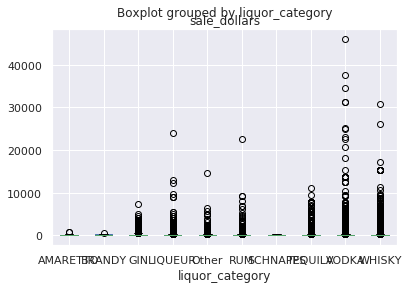

In [275]:
# pandas has some really powerful extensions to matplotlib for scientific computing 
ax = df.boxplot(column = 'sale_dollars', by = 'liquor_category')
ax



This box plot is graphing the distribution sale_dollars with the different categories of liquor we have available. Here, we can see there is a significant number of outliers across all categories, so much that you can't really see the boxes on each category. This would suggest we would want to look into a transform.

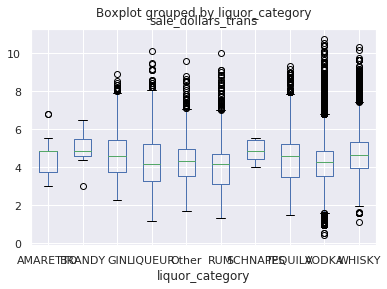

In [276]:
df['sale_dollars_trans'] = np.log(df['sale_dollars'])

gx = df.boxplot(column = 'sale_dollars_trans', by = 'liquor_category')
gx


This is much more helpful for us to see how our distribution of categories compares to one another. Vodka and Whiskey are still showing a wider range of outliers, however Liquer tends to have a wider bounding than the other categories, which suggests that it has a wide variety of pricing. On average, tequila looks to have the higher medium sale value, which suggest that more money is being spent on tequilla on average. 

Using Sales dollars trans will help address outliers in the future.

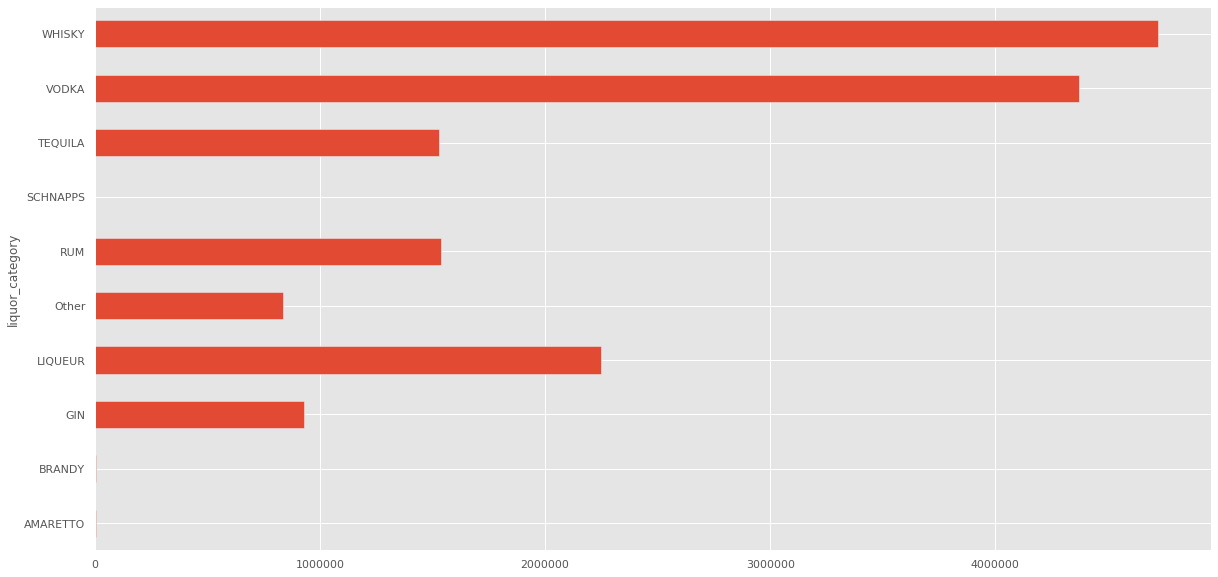

In [277]:
# Start by just plotting what we previsously grouped!
plt.style.use('ggplot')
plt.figure(figsize=(20,10))
df_grouped = df.groupby(by=['liquor_category'])
sales_rate = df_grouped.sale_dollars.sum()
ax = sales_rate.plot(kind='barh')

Looking at an agregate of our different alcohol categories, we can see that Whiskey generated the highest number of sales in our datase at close to 2.5 million followed by vodka at closer to 2 million. This chart seems to show that Vodka and Whiskey are the two most highest selling alcohols in the state of Iowa in 2019 with no one liquor coming close. 

In [278]:
df_grouped.head(5)

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,category,category_name,vendor_number,vendor_name,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,liquor_category,store_parent,month,year,monthyear,sale_dollars_trans
0,INV-23084400002,2019-11-07,3869,BOOTLEGGIN' BARZINI'S FIN,412 1st Ave,Coralville,52241,POINT (-91.565517 41.672672),52,JOHNSON,1.0921e+06,IMPORTED DISTILLED SPIRIT SPECIALTY,293,JINRO AMERICA INC,989215,JINRO CHAMISUL GRAPEFRUIT SOJU,20,375,3.85,5.78,20.0,115.60,7.50,1.98,Other,Other,Nov,2019,Nov-2019,4.750136
1,INV-23282200001,2019-11-18,4617,LICKETY LIQUOR,2501 HUBBELL AVE,Des Moines,50317,POINT (-93.570489 41.607817),77,POLK,1.0913e+06,NEUTRAL GRAIN SPIRITS FLAVORED,346,OLE SMOKY DISTILLERY LLC,86739,OLE SMOKY APPLE PIE MOONSHINE 70PRF MINI,8,50,8.75,13.13,1.0,13.13,0.05,0.01,Other,Other,Nov,2019,Nov-2019,2.574900
2,INV-19435800130,2019-05-17,2560,HY-VEE FOOD STORE / MARION,3600 Business Hwy 151 East,Marion,52302,blank,57,LINN,1.0421e+06,IMPORTED DRY GINS,35,BACARDI USA INC,28233,BOMBAY SAPPHIRE GIN,12,1000,16.50,24.75,6.0,148.50,6.00,1.58,GIN,Hy-Vee,May,2019,May-2019,5.000585
3,INV-23454200002,2019-11-25,2614,HY-VEE #3 FOOD & DRUGSTORE / DAVENPORT,1823 E Kimberly Rd,Davenport,52807,POINT (-90.548919 41.55678100000001),82,SCOTT,1.0113e+06,SINGLE BARREL BOURBON WHISKIES,184,FOUR ROSES DISTILLERY,18350,FOUR ROSES SINGLE BARREL,6,750,21.17,31.76,24.0,762.24,18.00,4.75,WHISKY,Hy-Vee,Nov,2019,Nov-2019,6.636261
4,INV-23541200001,2019-11-27,2629,HY-VEE FOOD STORE #2 / COUNCIL BLUFFS,1745 Madison Ave,Council Bluffs,51503,POINT (-95.825137 41.242732),78,POTTAWATTA,1.9012e+06,SPECIAL ORDER ITEMS,285,Charles Jacquin Et Cie,902291,SOOH BARTENDERS BANANAS OVER YOU,6,1750,9.31,13.97,12.0,167.64,21.00,5.54,Other,Hy-Vee,Nov,2019,Nov-2019,5.121819
5,INV-23540300028,2019-11-27,4312,I-80 LIQUOR / COUNCIL BLUFFS,2411 S 24TH ST #1,Council Bluffs,51501,POINT (-95.8792 41.238092),78,POTTAWATTA,1.0123e+06,SINGLE MALT SCOTCH,370,PERNOD RICARD USA,5037,GLENLIVET 12YR,12,1000,28.98,43.47,6.0,260.82,6.00,1.58,WHISKY,Other,Nov,2019,Nov-2019,5.563831
6,INV-19655400089,2019-05-29,2517,HY-VEE FOOD STORE #1 / NEWTON,1501 First Avenue East,Newton,50208,POINT (-93.034296 41.69916),50,JASPER,1.7011e+06,TEMPORARY & SPECIALTY PACKAGES,260,DIAGEO AMERICAS,77955,"SMIRNOFF RED, WHITE & BERRY MINI",12,500,4.90,7.35,12.0,88.20,6.00,1.58,Other,Hy-Vee,May,2019,May-2019,4.479607
7,INV-23687700099,2019-12-05,2545,HY-VEE DRUGSTORE / IOWA CITY,310 N 1st St,Iowa City,52245,POINT (-91.528105 42.207428),52,JOHNSON,1.7011e+06,TEMPORARY & SPECIALTY PACKAGES,259,Heaven Hill Brands,64489,CAROLANS SALTED CARAMEL,6,750,8.50,12.75,30.0,382.50,22.50,5.94,Other,Hy-Vee,Dec,2019,Dec-2019,5.946729
9,INV-23109300014,2019-11-08,5411,BLUEJAY MARKET,2810 Wills Ave,Perry,50220,POINT (-94.081127 41.838488),25,DALLAS,1.7011e+06,TEMPORARY & SPECIALTY PACKAGES,410,Patron Spirits Company,100258,PATRON SILVER VERSION 4.0,6,1000,33.34,50.01,6.0,300.06,6.00,1.58,TEQUILA,Other,Nov,2019,Nov-2019,5.703982
11,INV-19202100034,2019-05-07,5173,AUDUBON FOOD LAND,104 Market St,Audubon,50025,POINT (-94.93625 41.723057),5,AUDUBON,1.0815e+06,TRIPLE SEC,434,LUXCO INC,86310,LA PRIMA TRIPLE SEC,12,1000,3.00,4.50,4.0,18.00,4.00,1.05,LIQUEUR,Other,May,2019,May-2019,2.890372


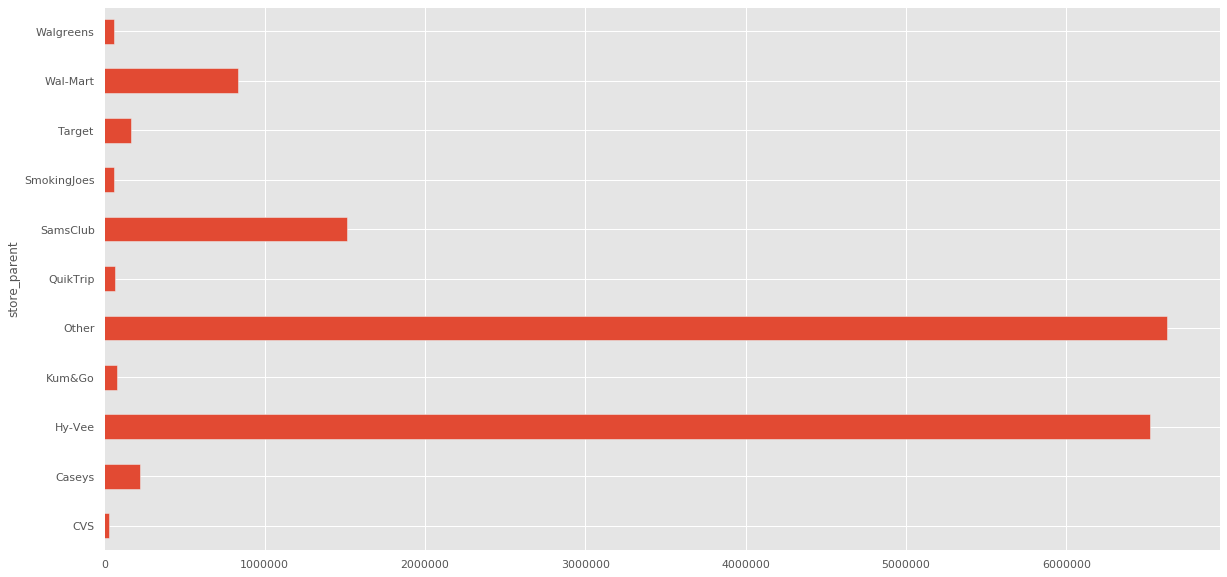

In [279]:
# Start by just plotting what we previsously grouped!
plt.style.use('ggplot')
plt.figure(figsize=(20,10))
df_grouped = df.groupby(by=['store_parent'])
sales_rate = df_grouped.sale_dollars.sum()
ax = sales_rate.plot(kind='barh')

For our stores in our dataset, as we discussed previously, we decided to focus on the big box retailers as our starting point, and lumped in the smaller stores into a category called "other". As we can see, the other column drove the greatest overall sales at over 4 million, however the Hy Vee in iowa was close to it at nearly 3.5 million in sales. In the state of Iowa, Hy Vee is a widely popular grocery store chain in Iowa that sales alocholic beverages as per the laws in Iowa. 

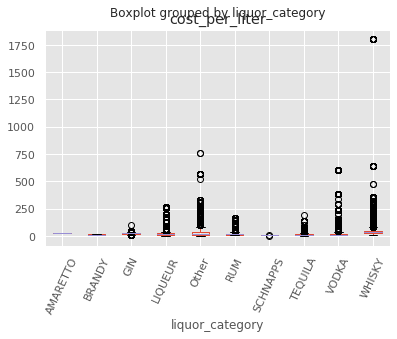

In [281]:
df['cost_per_liter'] = df['sale_dollars']/df['volume_sold_liters']


bx = df.boxplot(column = 'cost_per_liter', by = 'liquor_category')
plt.xticks(rotation=65)
bx

Looking at the cost per liter aggregate column. As we discussed previously, cost per liter is calculated via a calculation of total sales_dollars divided by the total volume_sold_ml. The idea of this calculation is to see the varying price of the liquors if we normalize by the volume and sale of the liquors in our set. 

Here, we can see that our distribution is right skewed with a large outlier for whiskey which is going for over 1750 per liter. Looking further into this datapoint, we can see that this datapoint represents Johnnie Walker Blue. 

That said, with the distribution of alcohol types, outside of Johnnie walker blue, we cans see that our cost per liter is going to have a greater than tenfold range, so, i would suggest we create a transform there as well. 

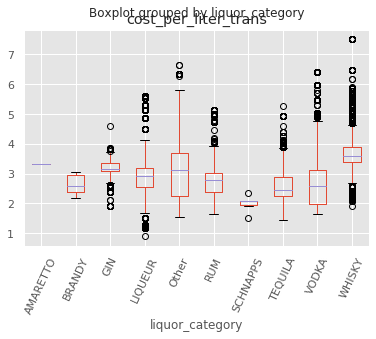

In [282]:
df['cost_per_liter_trans'] = np.log(df['cost_per_liter'])

zx = df.boxplot(column = 'cost_per_liter_trans', by = 'liquor_category')
plt.xticks(rotation=65)
zx

This new box plot shows some interesting insight into the distribution and the value placed on alcohol in our dataset. 

Gin and Tequilla - even with outliers, it is going to have a faily consistent price per liter. 
Liquer - Similar case as GIn, however, it's outliers go a little farther out. 
Other- as expected, has a very wide range with very few outliers. Since this represents all types of alcohol not covered in the other categories, the box plot shape is expected. 

Whiskey - Has a faily consistent bounding, however the number out outliers on either side is very large and larger than the other categories. 

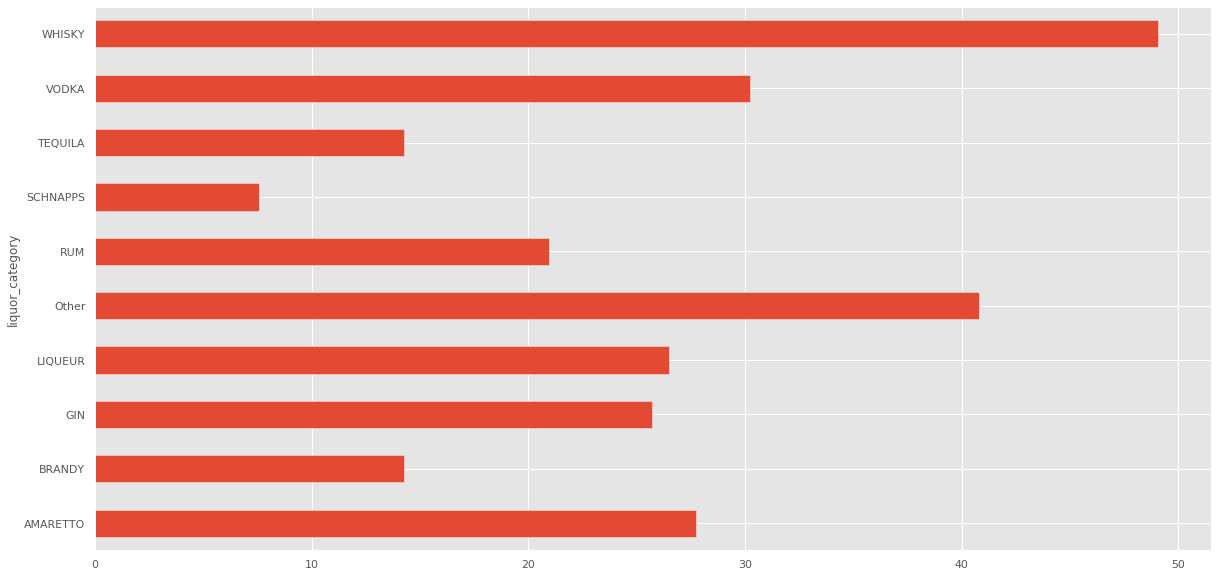

In [166]:
# Start by just plotting what we previsously grouped!
plt.style.use('ggplot')
plt.figure(figsize=(20,10))
df_grouped = df.groupby(by=['liquor_category'])
sales_rate = df_grouped.cost_per_liter.mean()
ax = sales_rate.plot(kind='barh')

This plot shows the grouped average cost per liter by the type of liquor in our dataset. Coming in at over 50 dollars per liter, whiskey is the most expensive alcohol in our dataset. However, some of that can come from the Johnnie Walker Blue we discussed previously, the common theme is that whiskey tends to be more expensive liter for liter than the other types of alcohol.

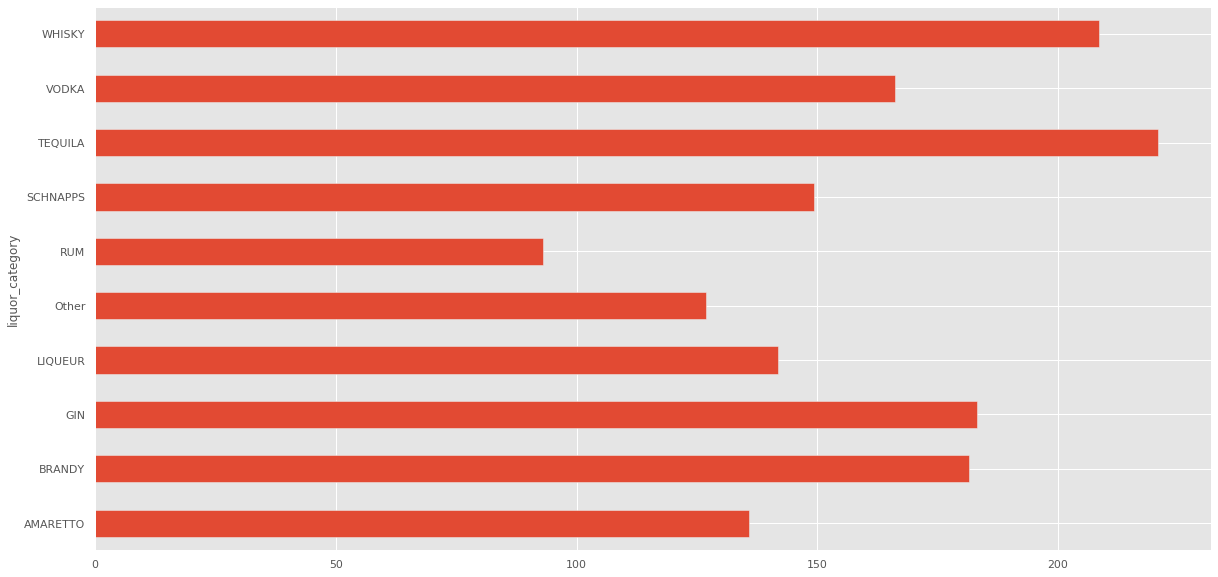

In [167]:
# Start by just plotting what we previsously grouped!
plt.style.use('ggplot')
plt.figure(figsize=(20,10))
df_grouped = df.groupby(by=['liquor_category'])
sales_rate = df_grouped.sale_dollars.mean()
ax = sales_rate.plot(kind='barh')

While whiskey had the highest average cost per liter, the vodka tended to have the highest sale value per purchase among all the alcohol types. This can be attributed to the volume in which vodka can be made and shipped, which likely affected the volume of sale. 

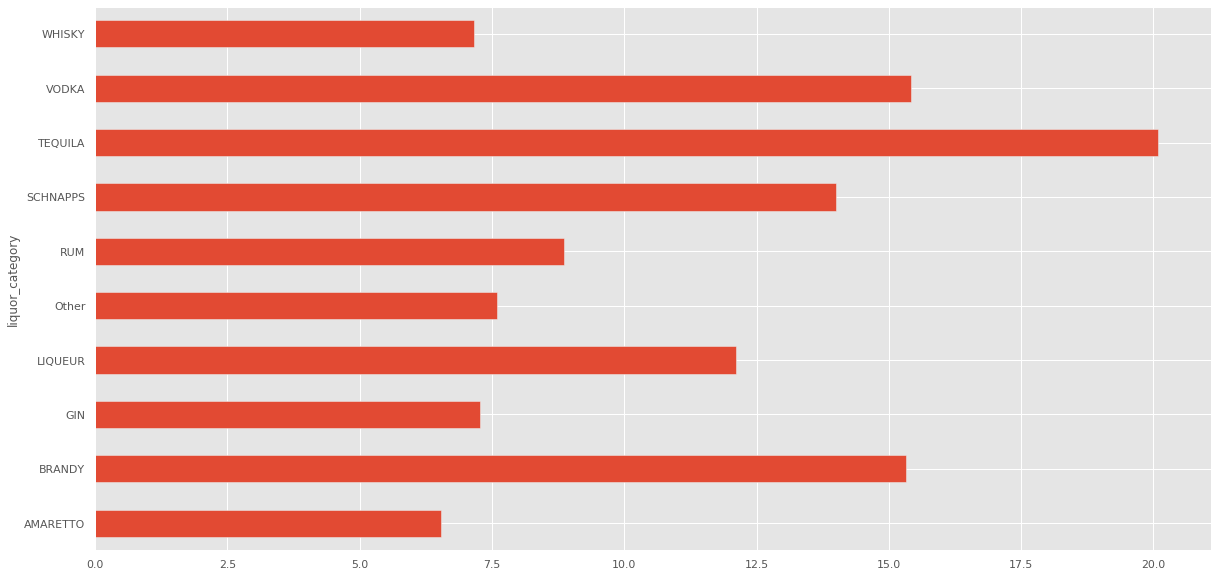

In [168]:
# Start by just plotting what we previsously grouped!
plt.style.use('ggplot')
plt.figure(figsize=(20,10))
df_grouped = df.groupby(by=['liquor_category'])
sales_rate = df_grouped.bottles_sold.mean()
ax = sales_rate.plot(kind='barh')

Looking at the average bottles sold per pack by way of the liquor categories in our dataset, tequila had the highest amount with over 20 bottles sold per purchase on average. This can be followed by vodka which was referenced earlier.

## Add whiskey specific analysis

Refining market to whiskey to gather further information about whiskey vendors. Since our analysis is going to focus strictly on whiskey sales, it will be important to see how the whiskey distribution looks within our dataset.  

The first thing we are going to reload our dataset as dfwhiskey and replace our nan values as blanks and convert our category_name strings as upper case variables. Like before we are going to categorize our liquors, add dates as well as store names so that we are working with a similar dataset as before. 

In [0]:
#analyze only whiskey
#seperate dataframe limited to whiskey
#dfwhiskey = pd.read_csv(r'/Users/jjschued/Documents/Github/7331DataMiningNotebooks/lab1/iowa_subset_2019_400k_random_rows.csv')
#dfwhiskey = pd.read_csv(r'/Users/danielclark/Desktop/SMU/data_mining/7331DataMiningNotebooks/lab1/iowa_subset_2019_400k_random_rows.csv')
dfwhiskey = pd.read_csv(url_dataset)


#convert nan to blanks
dfwhiskey = (dfwhiskey.replace(r'^\s*$', np.nan, regex=True))
dfwhiskey = (dfwhiskey.replace(np.nan, 'blank', regex=True))

#upper case category name for matching later
dfwhiskey['category_name'] = dfwhiskey['category_name'].str.upper()

#grouping all the liquors locations into liquor_category
dfwhiskey['liquor_category'] = 'Other'
dfwhiskey.loc[dfwhiskey['category_name'].str.contains('GINS'), 'liquor_category'] = 'GIN'
dfwhiskey.loc[dfwhiskey['category_name'].str.contains('GINS'), 'liquor_category'] = 'GIN'
dfwhiskey.loc[dfwhiskey['category_name'].str.contains('GIN'), 'liquor_category'] = 'GIN'
dfwhiskey.loc[dfwhiskey['category_name'].str.contains('RUMS'), 'liquor_category'] = 'RUM'
dfwhiskey.loc[dfwhiskey['category_name'].str.contains('RUM'), 'liquor_category'] = 'RUM'
dfwhiskey.loc[dfwhiskey['category_name'].str.contains('SCOTCH'), 'liquor_category'] = 'WHISKY'
dfwhiskey.loc[dfwhiskey['category_name'].str.contains('WHISKIES'), 'liquor_category'] = 'WHISKY'
dfwhiskey.loc[dfwhiskey['category_name'].str.contains('WHISKY'), 'liquor_category'] = 'WHISKY'
dfwhiskey.loc[dfwhiskey['category_name'].str.contains('WHISKEY'), 'liquor_category'] = 'WHISKY'
dfwhiskey.loc[dfwhiskey['category_name'].str.contains('RYE'), 'liquor_category'] = 'WHISKY'
dfwhiskey.loc[dfwhiskey['category_name'].str.contains('AMARETTO'), 'liquor_category'] = 'AMARETTO'
dfwhiskey.loc[dfwhiskey['category_name'].str.contains('BOURBON'), 'liquor_category'] = 'WHISKY'
dfwhiskey.loc[dfwhiskey['category_name'].str.contains('LIQUEURS'), 'liquor_category'] = 'LIQUEUR'
dfwhiskey.loc[dfwhiskey['category_name'].str.contains('LIQUEUR'), 'liquor_category'] = 'LIQUEUR'
dfwhiskey.loc[dfwhiskey['category_name'].str.contains('VODKAS'), 'liquor_category'] = 'VODKA'
dfwhiskey.loc[dfwhiskey['category_name'].str.contains('VODKA'), 'liquor_category'] = 'VODKA'
dfwhiskey.loc[dfwhiskey['category_name'].str.contains('BRANDY'), 'liquor_category'] = 'BRANDY'
dfwhiskey.loc[dfwhiskey['category_name'].str.contains('BRANDIES'), 'liquor_category'] = 'GIN'
dfwhiskey.loc[dfwhiskey['category_name'].str.contains('CREME'), 'liquor_category'] = 'SCHNAPPS'
dfwhiskey.loc[dfwhiskey['category_name'].str.contains('SCHNAPPS'), 'liquor_category'] = 'SCHNAPPS'
dfwhiskey.loc[dfwhiskey['category_name'].str.contains('TEQUILA'), 'liquor_category'] = 'TEQUILA'
dfwhiskey.loc[dfwhiskey['category_name'].str.contains('TEQUILAS'), 'liquor_category'] = 'TEQUILA'

#get a few stray not available categories per internet this is tequila
dfwhiskey.loc[dfwhiskey['item_description'] == 'Herradura Gold Reposado 6pak', 'liquor_category'] = "Tequila"
dfwhiskey.loc[dfwhiskey['item_description'] == 'Chambord Liqueur w/2 Glasses', 'liquor_category'] = "Liquers"

#grouping all the store locations into parent stores
dfwhiskey['store_parent'] = 'Other'
dfwhiskey.loc[dfwhiskey['store_name'].str.contains('Hy-Vee'), 'store_parent'] = 'Hy-Vee'
dfwhiskey.loc[dfwhiskey['store_name'].str.contains('Wal-Mart'), 'store_parent'] = 'Wal-Mart'
dfwhiskey.loc[dfwhiskey['store_name'].str.contains('SamsClub'), 'store_parent'] = 'SamsClub'
dfwhiskey.loc[dfwhiskey['store_name'].str.contains('Fareway'), 'store_parent'] = 'Fareway'
dfwhiskey.loc[dfwhiskey['store_name'].str.contains('Kum&Go'), 'store_parent'] = 'Kum&Go'
dfwhiskey.loc[dfwhiskey['store_name'].str.contains('CVS'), 'store_parent'] = 'CVS'
dfwhiskey.loc[dfwhiskey['store_name'].str.contains('Target'), 'store_parent'] = 'Target'
dfwhiskey.loc[dfwhiskey['store_name'].str.contains('Caseys'), 'store_parent'] = 'Caseys'
dfwhiskey.loc[dfwhiskey['store_name'].str.contains('Dahls'), 'store_parent'] = 'Dahls'
dfwhiskey.loc[dfwhiskey['store_name'].str.contains('WAL-MART'), 'store_parent'] = 'Wal-Mart'
dfwhiskey.loc[dfwhiskey['store_name'].str.contains('HY-VEE'), 'store_parent'] = 'Hy-Vee'
dfwhiskey.loc[dfwhiskey['store_name'].str.contains('KUM&GO'), 'store_parent'] = 'Kum&Go'
dfwhiskey.loc[dfwhiskey['store_name'].str.contains('QuikTrip'), 'store_parent'] = 'QuikTrip'


#labored conversion of dates to month year and month year by converting to strings
dfwhiskey['month'] = pd.DatetimeIndex(dfwhiskey['date']).month
dfwhiskey['year'] = pd.DatetimeIndex(dfwhiskey['date']).year

dfwhiskey.loc[dfwhiskey['month'] ==1 , 'month'] = 'Jan'
dfwhiskey.loc[dfwhiskey['month'] ==2 , 'month'] = 'Feb'
dfwhiskey.loc[dfwhiskey['month'] ==3 , 'month'] = 'Mar'
dfwhiskey.loc[dfwhiskey['month'] ==4 , 'month'] = 'Apr'
dfwhiskey.loc[dfwhiskey['month'] ==5 , 'month'] = 'May'
dfwhiskey.loc[dfwhiskey['month'] ==6 , 'month'] = 'Jun'
dfwhiskey.loc[dfwhiskey['month'] ==7 , 'month'] = 'Jul'
dfwhiskey.loc[dfwhiskey['month'] ==8 , 'month'] = 'Aug'
dfwhiskey.loc[dfwhiskey['month'] ==9 , 'month'] = 'Sep'
dfwhiskey.loc[dfwhiskey['month'] ==10 , 'month'] = 'Oct'
dfwhiskey.loc[dfwhiskey['month'] ==11 , 'month'] = 'Nov'
dfwhiskey.loc[dfwhiskey['month'] ==12 , 'month'] = 'Dec'


dfwhiskey.loc[dfwhiskey['year'] ==2012 , 'year'] = '2012'
dfwhiskey.loc[dfwhiskey['year'] ==2013 , 'year'] = '2013'
dfwhiskey.loc[dfwhiskey['year'] ==2014 , 'year'] = '2014'
dfwhiskey.loc[dfwhiskey['year'] ==2015 , 'year'] = '2015'
dfwhiskey.loc[dfwhiskey['year'] ==2016 , 'year'] = '2016'
dfwhiskey.loc[dfwhiskey['year'] ==2017 , 'year'] = '2017'
dfwhiskey.loc[dfwhiskey['year'] ==2018 , 'year'] = '2018'
dfwhiskey.loc[dfwhiskey['year'] ==2019 , 'year'] = '2019'

#merge year and month together
dfwhiskey['monthyear'] = dfwhiskey['month'] + "-" + dfwhiskey['year']


Here's the head of our dataset so we can see how it looks.

In [170]:
dfwhiskey.head()

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,category,category_name,vendor_number,vendor_name,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,liquor_category,store_parent,month,year,monthyear
0,INV-23084400002,2019-11-07,3869,Bootleggin' Barzini's Fin,412 1st Ave,Coralville,52241,POINT (-91.565517 41.672672),52,JOHNSON,1.0921e+06,IMPORTED DISTILLED SPIRIT SPECIALTY,293,JINRO AMERICA INC,989215,Jinro Chamisul Grapefruit Soju,20,375,3.85,5.78,20,115.60,7.50,1.98,Other,Other,Nov,2019,Nov-2019
1,INV-23282200001,2019-11-18,4617,Lickety Liquor,2501 HUBBELL AVE,Des Moines,50317,POINT (-93.570489 41.607817),77,POLK,1.0913e+06,NEUTRAL GRAIN SPIRITS FLAVORED,346,OLE SMOKY DISTILLERY LLC,86739,Ole Smoky Apple Pie Moonshine 70prf Mini,8,50,8.75,13.13,1,13.13,0.05,0.01,Other,Other,Nov,2019,Nov-2019
2,INV-19435800130,2019-05-17,2560,Hy-Vee Food Store / Marion,3600 Business Hwy 151 East,Marion,52302,blank,57,LINN,1.0421e+06,IMPORTED DRY GINS,35,BACARDI USA INC,28233,Bombay Sapphire Gin,12,1000,16.50,24.75,6,148.50,6.00,1.58,GIN,Hy-Vee,May,2019,May-2019
3,INV-23454200002,2019-11-25,2614,Hy-Vee #3 Food & Drugstore / Davenport,1823 E Kimberly Rd,Davenport,52807,POINT (-90.548919 41.55678100000001),82,SCOTT,1.0113e+06,SINGLE BARREL BOURBON WHISKIES,184,FOUR ROSES DISTILLERY,18350,Four Roses Single Barrel,6,750,21.17,31.76,24,762.24,18.00,4.75,WHISKY,Hy-Vee,Nov,2019,Nov-2019
4,INV-23541200001,2019-11-27,2629,Hy-Vee Food Store #2 / Council Bluffs,1745 Madison Ave,Council Bluffs,51503,POINT (-95.825137 41.242732),78,POTTAWATTA,1.9012e+06,SPECIAL ORDER ITEMS,285,Charles Jacquin Et Cie,902291,SOOH Bartenders Bananas Over You,6,1750,9.31,13.97,12,167.64,21.00,5.54,Other,Hy-Vee,Nov,2019,Nov-2019


Next, we are going to redefine our dataset to focus entirely on the whiskey category and rename our original dataset as dfwhiskey. 

In [0]:
dfwhiskey = dfwhiskey[dfwhiskey['liquor_category']=='WHISKY']

Here is another top view of our dataset to show how it looks from above. 

In [172]:
dfwhiskey.head()

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,category,category_name,vendor_number,vendor_name,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,liquor_category,store_parent,month,year,monthyear
3,INV-23454200002,2019-11-25,2614,Hy-Vee #3 Food & Drugstore / Davenport,1823 E Kimberly Rd,Davenport,52807,POINT (-90.548919 41.55678100000001),82,SCOTT,1.0113e+06,SINGLE BARREL BOURBON WHISKIES,184,FOUR ROSES DISTILLERY,18350,Four Roses Single Barrel,6,750,21.17,31.76,24,762.24,18.0,4.75,WHISKY,Hy-Vee,Nov,2019,Nov-2019
5,INV-23540300028,2019-11-27,4312,I-80 Liquor / Council Bluffs,2411 S 24TH ST #1,Council Bluffs,51501,POINT (-95.8792 41.238092),78,POTTAWATTA,1.0123e+06,SINGLE MALT SCOTCH,370,PERNOD RICARD USA,5037,Glenlivet 12YR,12,1000,28.98,43.47,6,260.82,6.0,1.58,WHISKY,Other,Nov,2019,Nov-2019
15,INV-19970300001,2019-06-13,2675,Hy-Vee #2 / Coralville,3285 Crosspark Rd,Coralville,52241,POINT (-91.60627100000002 41.721438),52,JOHNSON,1.0116e+06,STRAIGHT RYE WHISKIES,287,CHATHAM IMPORTS INC,27060,Michters US1 Kentucky Straight Single Barrel R...,6,750,21.59,32.39,18,583.02,13.5,3.56,WHISKY,Hy-Vee,Jun,2019,Jun-2019
24,INV-23645000007,2019-12-03,5866,Hometown Family Market,310 2nd St,Gladbrook,50635,POINT (-92.716422 42.187653),86,TAMA,1.0116e+06,STRAIGHT RYE WHISKIES,255,Infinium Spirits,27175,Templeton 4YR Rye,6,1000,21.00,31.50,2,63.00,2.0,0.52,WHISKY,Other,Dec,2019,Dec-2019
29,INV-19201600066,2019-05-07,2651,Hy-Vee / Waverly,1311 4 Street SW,Waverly,50677,POINT (-92.475403 42.712263),9,BREMER,1.0116e+06,STRAIGHT RYE WHISKIES,255,Infinium Spirits,27102,Templeton 4YR Rye,6,750,18.09,27.14,30,814.20,22.5,5.94,WHISKY,Hy-Vee,May,2019,May-2019


Next, we are going to do a series of calculations to add new columns to our dataset which provides some insight to the sales data of our whiskies. 

These include the following new features:
- cost per liter = sale_dollars / volume_sale_ml
- profit = state_bottle_retail / bottles_sold
- totalcost = state_bottle_cost * bottles_sold
- revenue = state_bottle_retail * bottles_sold
- grossmargin = (revenue - totalcost)/revenue

Ultimately, this is going to give us a clear view of the profatability, and the market size of whiskey so we can better analyze and predict within the dataset.

In [0]:
#do some calculations for cost and profit
dfwhiskey['cost_per_liter'] = dfwhiskey['sale_dollars']/dfwhiskey['volume_sold_liters']

In [0]:
dfwhiskey['profit'] = dfwhiskey['state_bottle_retail']*dfwhiskey['bottles_sold'] - dfwhiskey['state_bottle_cost']* dfwhiskey['bottles_sold']

In [0]:
dfwhiskey['totalcost'] = dfwhiskey['state_bottle_cost']* dfwhiskey['bottles_sold']

In [0]:
dfwhiskey['revenue'] = dfwhiskey['state_bottle_retail']*dfwhiskey['bottles_sold']

In [0]:
dfwhiskey['grossmargin'] = (dfwhiskey['revenue'] - dfwhiskey['totalcost']) / dfwhiskey['revenue']

Here, we sorted gross margin of sale within our data set to get a clearer view of how margins tend to look within the sales in our dataset. 

As we can see, there is a 33% margin that appears across almost all of our sales when you calculate the percentage of what is remaining from the cost over the revenue. We are thiking that is a standard state tax cost for whiskies in the state of Iowa.

In [0]:
#lets do the transforms we did earlier in the EDA
dfwhiskey['sale_dollars_trans'] = np.log(dfwhiskey['sale_dollars'])
dfwhiskey['cost_per_liter_trans'] = np.log(dfwhiskey['cost_per_liter'])

In [179]:
dfwhiskey.sort_values(by='grossmargin', ascending=False).head(100)

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,category,category_name,vendor_number,vendor_name,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,liquor_category,store_parent,month,year,monthyear,cost_per_liter,profit,totalcost,revenue,grossmargin,sale_dollars_trans,cost_per_liter_trans
121625,INV-18344800004,2019-03-26,5443,1st Stop Beverage Shop,2839 East University Ave.,Des Moines,50317,POINT (-93.561517 41.600476),77,POLK,1.0122e+06,SCOTCH WHISKIES,55,SAZERAC NORTH AMERICA,8824,Lauder's,24,375,3.21,4.82,24,115.68,9.00,2.37,WHISKY,Other,Mar,2019,Mar-2019,12.853333,38.64,77.04,115.68,0.334025,4.750828,2.553603
121334,INV-19122500001,2019-05-02,2501,Hy-Vee #2 / Ames,640 Lincolnway,Ames,50010,POINT (-93.619455 42.022848),85,STORY,1.0122e+06,SCOTCH WHISKIES,55,SAZERAC NORTH AMERICA,8824,Lauder's,24,375,3.21,4.82,6,28.92,2.25,0.59,WHISKY,Hy-Vee,May,2019,May-2019,12.853333,9.66,19.26,28.92,0.334025,3.364533,2.553603
121653,INV-19341100016,2019-05-14,5286,Sauce,"108, College",Iowa City,52240,blank,52,JOHNSON,1.0122e+06,SCOTCH WHISKIES,55,SAZERAC NORTH AMERICA,8824,Lauder's,24,375,3.21,4.82,24,115.68,9.00,2.37,WHISKY,Other,May,2019,May-2019,12.853333,38.64,77.04,115.68,0.334025,4.750828,2.553603
121329,INV-17879500032,2019-03-04,2560,Hy-Vee Food Store / Marion,3600 Business Hwy 151 East,Marion,52302,blank,57,LINN,1.0122e+06,SCOTCH WHISKIES,55,SAZERAC NORTH AMERICA,8824,Lauder's,24,375,3.21,4.82,6,28.92,2.25,0.59,WHISKY,Hy-Vee,Mar,2019,Mar-2019,12.853333,9.66,19.26,28.92,0.334025,3.364533,2.553603
36719,INV-19151100019,2019-05-03,4106,Hartig Drug Company #3/JFK,2255 John F Kennedy Rd,Dubuque,52002,POINT (-90.72051800000001 42.511352),31,DUBUQUE,1.0122e+06,SCOTCH WHISKIES,55,SAZERAC NORTH AMERICA,8824,Lauder's,24,375,3.21,4.82,3,14.46,1.12,0.29,WHISKY,Other,May,2019,May-2019,12.910714,4.83,9.63,14.46,0.334025,2.671386,2.558058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38576,INV-16714800233,2019-01-03,2603,Hy-Vee Wine and Spirits / Bettendorf,2890 Devils Glen Road,Bettendorf,52722,POINT (-90.483701 41.552338),82,SCOTT,1.0122e+06,SCOTCH WHISKIES,260,DIAGEO AMERICAS,10006,Scoresby Rare Scotch,12,750,5.13,7.70,2,15.40,1.50,0.39,WHISKY,Hy-Vee,Jan,2019,Jan-2019,10.266667,5.14,10.26,15.40,0.333766,2.734368,2.328902
121804,INV-21117100019,2019-08-08,4135,Fareway Stores #925 / Altoona,620 SE 8th St,Altoona,50009,POINT (-93.458606 41.644082000000004),77,POLK,1.0122e+06,SCOTCH WHISKIES,421,SAZERAC COMPANY INC,10006,Scoresby Rare Scotch,12,750,5.13,7.70,2,15.40,1.50,0.39,WHISKY,Fareway,Aug,2019,Aug-2019,10.266667,5.14,10.26,15.40,0.333766,2.734368,2.328902
78917,INV-20962200017,2019-07-31,4247,Fareway Stores #879 / Belmond,512 River Ave N,Belmond,50421,POINT (-93.616788 42.850357),99,WRIGHT,1.0122e+06,SCOTCH WHISKIES,55,SAZERAC NORTH AMERICA,8826,Lauder's Scotch,12,750,5.13,7.70,4,28.80,3.00,0.79,WHISKY,Fareway,Jul,2019,Jul-2019,9.600000,10.28,20.52,30.80,0.333766,3.360375,2.261763
78831,INV-17201100004,2019-01-28,2591,Hy-Vee Wine and Spirits / Atlantic,1602 E 7th St,Atlantic,50022,POINT (-94.990031 41.403856),15,CASS,1.0122e+06,SCOTCH WHISKIES,260,DIAGEO AMERICAS,10006,Scoresby Rare Scotch,12,750,5.13,7.70,4,30.80,3.00,0.79,WHISKY,Hy-Vee,Jan,2019,Jan-2019,10.266667,10.28,20.52,30.80,0.333766,3.427515,2.328902


Looking at more grossmargin values, we still see the same 33%

In [180]:
dfwhiskey.head(10)

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,category,category_name,vendor_number,vendor_name,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,liquor_category,store_parent,month,year,monthyear,cost_per_liter,profit,totalcost,revenue,grossmargin,sale_dollars_trans,cost_per_liter_trans
3,INV-23454200002,2019-11-25,2614,Hy-Vee #3 Food & Drugstore / Davenport,1823 E Kimberly Rd,Davenport,52807,POINT (-90.548919 41.55678100000001),82,SCOTT,1.0113e+06,SINGLE BARREL BOURBON WHISKIES,184,FOUR ROSES DISTILLERY,18350,Four Roses Single Barrel,6,750,21.17,31.76,24,762.24,18.0,4.75,WHISKY,Hy-Vee,Nov,2019,Nov-2019,42.346667,254.16,508.08,762.24,0.333438,6.636261,3.745890
5,INV-23540300028,2019-11-27,4312,I-80 Liquor / Council Bluffs,2411 S 24TH ST #1,Council Bluffs,51501,POINT (-95.8792 41.238092),78,POTTAWATTA,1.0123e+06,SINGLE MALT SCOTCH,370,PERNOD RICARD USA,5037,Glenlivet 12YR,12,1000,28.98,43.47,6,260.82,6.0,1.58,WHISKY,Other,Nov,2019,Nov-2019,43.470000,86.94,173.88,260.82,0.333333,5.563831,3.772071
15,INV-19970300001,2019-06-13,2675,Hy-Vee #2 / Coralville,3285 Crosspark Rd,Coralville,52241,POINT (-91.60627100000002 41.721438),52,JOHNSON,1.0116e+06,STRAIGHT RYE WHISKIES,287,CHATHAM IMPORTS INC,27060,Michters US1 Kentucky Straight Single Barrel R...,6,750,21.59,32.39,18,583.02,13.5,3.56,WHISKY,Hy-Vee,Jun,2019,Jun-2019,43.186667,194.40,388.62,583.02,0.333436,6.368221,3.765532
24,INV-23645000007,2019-12-03,5866,Hometown Family Market,310 2nd St,Gladbrook,50635,POINT (-92.716422 42.187653),86,TAMA,1.0116e+06,STRAIGHT RYE WHISKIES,255,Infinium Spirits,27175,Templeton 4YR Rye,6,1000,21.00,31.50,2,63.00,2.0,0.52,WHISKY,Other,Dec,2019,Dec-2019,31.500000,21.00,42.00,63.00,0.333333,4.143135,3.449988
29,INV-19201600066,2019-05-07,2651,Hy-Vee / Waverly,1311 4 Street SW,Waverly,50677,POINT (-92.475403 42.712263),9,BREMER,1.0116e+06,STRAIGHT RYE WHISKIES,255,Infinium Spirits,27102,Templeton 4YR Rye,6,750,18.09,27.14,30,814.20,22.5,5.94,WHISKY,Hy-Vee,May,2019,May-2019,36.186667,271.50,542.70,814.20,0.333456,6.702206,3.588691
30,INV-23443700008,2019-11-25,2536,HY-VEE / PLEASANT HILL,4815 Maple Drive,Pleasant Hill,50317,POINT (-93.519187 41.598109),77,Polk,1.0123e+06,SINGLE MALT SCOTCH,370,PERNOD RICARD USA,5036,Glenlivet 12YR,12,750,24.48,36.72,60,2203.20,45.0,11.88,WHISKY,Hy-Vee,Nov,2019,Nov-2019,48.960000,734.40,1468.80,2203.20,0.333333,7.697666,3.891004
32,INV-20172700090,2019-06-24,2512,Hy-Vee Wine and Spirits / Iowa City,1720 Waterfront Dr,Iowa City,52240,POINT (-91.53046300000001 41.642764),52,JOHNSON,1.0116e+06,STRAIGHT RYE WHISKIES,65,Jim Beam Brands,27066,Old Overholt Rye,12,750,11.54,17.31,24,415.44,18.0,4.75,WHISKY,Hy-Vee,Jun,2019,Jun-2019,23.080000,138.48,276.96,415.44,0.333333,6.029338,3.138966
79,INV-23172800009,2019-11-12,3881,7 Rayos Liquor Store,120 E Main St,Marshalltown,50158,POINT (-92.9104 42.049166),64,MARSHALL,1.0116e+06,STRAIGHT RYE WHISKIES,255,Infinium Spirits,27175,Templeton 4YR Rye,6,1000,21.00,31.50,4,126.00,4.0,1.05,WHISKY,Other,Nov,2019,Nov-2019,31.500000,42.00,84.00,126.00,0.333333,4.836282,3.449988
81,INV-19221100078,2019-05-07,5351,Downtown Liquor,1203 5th St.,Sioux City,51101,POINT (-96.394671 42.495324),97,WOODBURY,1.0123e+06,SINGLE MALT SCOTCH,370,PERNOD RICARD USA,5037,Glenlivet 12YR,12,1000,28.98,43.47,2,86.94,2.0,0.52,WHISKY,Other,May,2019,May-2019,43.470000,28.98,57.96,86.94,0.333333,4.465218,3.772071
85,INV-23526800002,2019-11-27,2521,Hy-Vee Food and Drug / Grand / WDM,1990 Grand Avenue,West Des Moines,50265,POINT (-93.73162 41.571127),77,POLK,1.0117e+06,CORN WHISKIES,566,"Foundry Distilling Company, LLC",26613,Foundry Corn Whiskey,6,750,40.00,60.00,18,1080.00,13.5,3.56,WHISKY,Hy-Vee,Nov,2019,Nov-2019,80.000000,360.00,720.00,1080.00,0.333333,6.984716,4.382027


In [181]:
df_grouped = dfwhiskey.groupby(by=['vendor_name'])
df_grouped.head()

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,category,category_name,vendor_number,vendor_name,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,liquor_category,store_parent,month,year,monthyear,cost_per_liter,profit,totalcost,revenue,grossmargin,sale_dollars_trans,cost_per_liter_trans
3,INV-23454200002,2019-11-25,2614,Hy-Vee #3 Food & Drugstore / Davenport,1823 E Kimberly Rd,Davenport,52807,POINT (-90.548919 41.55678100000001),82,SCOTT,1.0113e+06,SINGLE BARREL BOURBON WHISKIES,184,FOUR ROSES DISTILLERY,18350,Four Roses Single Barrel,6,750,21.17,31.76,24,762.24,18.00,4.75,WHISKY,Hy-Vee,Nov,2019,Nov-2019,42.346667,254.16,508.08,762.24,0.333438,6.636261,3.745890
5,INV-23540300028,2019-11-27,4312,I-80 Liquor / Council Bluffs,2411 S 24TH ST #1,Council Bluffs,51501,POINT (-95.8792 41.238092),78,POTTAWATTA,1.0123e+06,SINGLE MALT SCOTCH,370,PERNOD RICARD USA,5037,Glenlivet 12YR,12,1000,28.98,43.47,6,260.82,6.00,1.58,WHISKY,Other,Nov,2019,Nov-2019,43.470000,86.94,173.88,260.82,0.333333,5.563831,3.772071
15,INV-19970300001,2019-06-13,2675,Hy-Vee #2 / Coralville,3285 Crosspark Rd,Coralville,52241,POINT (-91.60627100000002 41.721438),52,JOHNSON,1.0116e+06,STRAIGHT RYE WHISKIES,287,CHATHAM IMPORTS INC,27060,Michters US1 Kentucky Straight Single Barrel R...,6,750,21.59,32.39,18,583.02,13.50,3.56,WHISKY,Hy-Vee,Jun,2019,Jun-2019,43.186667,194.40,388.62,583.02,0.333436,6.368221,3.765532
24,INV-23645000007,2019-12-03,5866,Hometown Family Market,310 2nd St,Gladbrook,50635,POINT (-92.716422 42.187653),86,TAMA,1.0116e+06,STRAIGHT RYE WHISKIES,255,Infinium Spirits,27175,Templeton 4YR Rye,6,1000,21.00,31.50,2,63.00,2.00,0.52,WHISKY,Other,Dec,2019,Dec-2019,31.500000,21.00,42.00,63.00,0.333333,4.143135,3.449988
29,INV-19201600066,2019-05-07,2651,Hy-Vee / Waverly,1311 4 Street SW,Waverly,50677,POINT (-92.475403 42.712263),9,BREMER,1.0116e+06,STRAIGHT RYE WHISKIES,255,Infinium Spirits,27102,Templeton 4YR Rye,6,750,18.09,27.14,30,814.20,22.50,5.94,WHISKY,Hy-Vee,May,2019,May-2019,36.186667,271.50,542.70,814.20,0.333456,6.702206,3.588691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246015,INV-21252600005,2019-08-15,4129,Cyclone Liquors,626 Lincoln Way,Ames,50010,POINT (-93.618911 42.022854),85,STORY,1.0116e+06,STRAIGHT RYE WHISKIES,608,Wilderness Trail Distillery,926610,Wilderness Trail Settlers Select,6,750,30.00,45.00,6,270.00,4.50,1.18,WHISKY,Other,Aug,2019,Aug-2019,60.000000,90.00,180.00,270.00,0.333333,5.598422,4.094345
314264,INV-21229200003,2019-08-14,3773,Benz Distributing,501 7th Ave SE,Cedar Rapids,52401,POINT (-91.659875 41.97574),57,LINN,1.0124e+06,IRISH WHISKIES,91,Castle Brands,15560,Clontarf 1014 Classic Blend,6,750,9.99,14.99,18,269.82,13.50,3.56,WHISKY,Other,Aug,2019,Aug-2019,19.986667,90.00,179.82,269.82,0.333556,5.597755,2.995065
314265,INV-17524000177,2019-02-13,4129,Cyclone Liquors,626 Lincoln Way,Ames,50010,POINT (-93.618911 42.022854),85,STORY,1.0124e+06,IRISH WHISKIES,91,Castle Brands,15560,Clontarf 1014 Classic Blend,6,750,9.99,14.99,1,14.99,0.75,0.19,WHISKY,Other,Feb,2019,Feb-2019,19.986667,5.00,9.99,14.99,0.333556,2.707383,2.995065
314266,INV-19589600071,2019-05-24,3868,Wal-Mart 3630 / Marion,5491 Business Hwy 151,Marion,52302,blank,57,LINN,1.0124e+06,IRISH WHISKIES,91,Castle Brands,15560,Clontarf 1014 Classic Blend,6,750,9.99,14.99,6,89.94,4.50,1.18,WHISKY,Wal-Mart,May,2019,May-2019,19.986667,30.00,59.94,89.94,0.333556,4.499143,2.995065


To look into some aggregate sums within our whiskey dataset, we are going to create new varuables for the sum of bottles sold and sale_dollars, as well as the mean of cost per liter and gross margin. 

Also, we will create datagrames for each so we can see how the whiskey's distribute in these aggregate figures.

In [0]:
sales_rateq = df_grouped.bottles_sold.sum()
sales_rated = df_grouped.sale_dollars.sum()
sales_ratecpl = df_grouped.cost_per_liter.mean()
salesgm = df_grouped.grossmargin.mean()

In [0]:
dfsr = pd.DataFrame(sales_rateq)
dfsdol = pd.DataFrame(sales_rated)
dfscpl = pd.DataFrame(sales_ratecpl)
dfsg = pd.DataFrame(salesgm)

In [184]:
dfsr.sort_values(by='bottles_sold', ascending=False).head(10)

,bottles_sold
vendor_name,
PERNOD RICARD USA,105068
DIAGEO AMERICAS,29552
Infinium Spirits,22497
William Grant & Sons Inc,15926
SAZERAC NORTH AMERICA,10698
SAZERAC COMPANY INC,10665
Jim Beam Brands,8651
BACARDI USA INC,7716
CEDAR RIDGE VINEYARDS LL,4411


Looking at the top 10 bottles sold in the whiskey category, we can see that the number one on the list is Pernod Ricard at over 100k bolttles sold, followed distantly by Dieago Americas at 29,500. 

In [185]:
dfsdol.sort_values(by='sale_dollars', ascending=False).head(10)

,sale_dollars
vendor_name,
PERNOD RICARD USA,2965631.76
DIAGEO AMERICAS,935867.44
Infinium Spirits,634224.71
William Grant & Sons Inc,509568.03
Jim Beam Brands,227406.10
BACARDI USA INC,216439.87
SAZERAC COMPANY INC,188508.57
Edrington Group USA LLC,185043.45
MOET HENNESSY USA,168206.25


As a function of bottles sold, we are seeing a similar distirbution with regards to sale_dollars in our top whiskies. Pernod Richard is nearing 3 million dollars in sales followed by Diageo Americas that is under 1 million dollars in sales. 

In [186]:
dfscpl.sort_values(by='cost_per_liter', ascending=False).head(10)

,cost_per_liter
vendor_name,
PACIFIC EDGE WINE & SPIRITS,145.564444
IMPEX BEVERAGE INC,123.086667
HOTALING & CO,104.243810
W J Deutsch & Sons LTD,93.320000
GoAmericaGo Beverages LLC,89.461075
MOET HENNESSY USA,74.180870
"Foundry Distilling Company, LLC",71.983333
Vision Wine & Spirit LLC,69.010256
Paterno Imports LTD,68.098667


Interestingly, looking at the high cost per liter vendors, Pactific Edge Wine and Spirits has the highest cost per liter at over 115 dollars, followed by Impex Beverage and Hotaling at just over 100 dollars. 

In [187]:
salesbyvendor = pd.merge(dfsr, dfsdol, how = 'left', on='vendor_name')
salesbyvendor = pd.merge(salesbyvendor, dfscpl, how = 'left', on='vendor_name')
salesbyvendor = pd.merge(salesbyvendor, dfsg, how = 'left', on='vendor_name')
salesbyvendor

,bottles_sold,sale_dollars,cost_per_liter,grossmargin
vendor_name,,,,
"American Heritage Distillers, LLC",12,189.60,21.066667,0.333544
BACARDI USA INC,7716,216439.87,28.791171,0.333334
BAD BEAR ENTERPRISES LLC,413,18987.00,60.047619,0.333333
Brown Forman Corp.,2284,68098.15,41.052515,0.333437
CEDAR RIDGE VINEYARDS LL,4411,142926.26,44.172657,0.333396
...,...,...,...,...
Three Rangers,2,74.64,49.760000,0.333333
Vision Wine & Spirit LLC,54,2817.91,69.010256,0.333352
W J Deutsch & Sons LTD,19,1329.81,93.320000,0.333333


Next, we are going to merge our datasets so that we can group our measures of bottles sold, sale_dollars, cost_per_liter and gross margin by our 61 vendors, so we can see how they rank in our key finance values. 

In [188]:
salesbyvendor.sort_values(by='cost_per_liter', ascending=False).head(10)

,bottles_sold,sale_dollars,cost_per_liter,grossmargin
vendor_name,,,,
PACIFIC EDGE WINE & SPIRITS,36,3930.24,145.564444,0.333336
IMPEX BEVERAGE INC,36,3681.12,123.086667,0.333347
HOTALING & CO,48,3570.24,104.243810,0.333338
W J Deutsch & Sons LTD,19,1329.81,93.320000,0.333333
GoAmericaGo Beverages LLC,769,50006.25,89.461075,0.333375
MOET HENNESSY USA,3993,168206.25,74.180870,0.333417
"Foundry Distilling Company, LLC",499,15221.40,71.983333,0.333368
Vision Wine & Spirit LLC,54,2817.91,69.010256,0.333352
Paterno Imports LTD,30,1532.22,68.098667,0.333359


In [189]:
salesbyvendor.sort_values(by='sale_dollars', ascending=False).head(10)

,bottles_sold,sale_dollars,cost_per_liter,grossmargin
vendor_name,,,,
PERNOD RICARD USA,105068,2965631.76,50.308440,0.333377
DIAGEO AMERICAS,29552,935867.44,59.427849,0.333368
Infinium Spirits,22497,634224.71,38.625414,0.333439
William Grant & Sons Inc,15926,509568.03,51.849234,0.333346
Jim Beam Brands,8651,227406.10,36.642989,0.333391
BACARDI USA INC,7716,216439.87,28.791171,0.333334
SAZERAC COMPANY INC,10665,188508.57,17.979126,0.333383
Edrington Group USA LLC,4200,185043.45,66.699662,0.333400
MOET HENNESSY USA,3993,168206.25,74.180870,0.333417


In [190]:
salesbyvendor.sort_values(by='grossmargin', ascending=False).head(100)

,bottles_sold,sale_dollars,cost_per_liter,grossmargin
vendor_name,,,,
Castle Brands,232,3792.74,21.614884,0.333551
"American Heritage Distillers, LLC",12,189.60,21.066667,0.333544
Phillips Beverage,3317,58490.20,27.621371,0.333481
DUNKEL CORPORATION,360,9154.80,33.906667,0.333464
Cats Eye Distillery,199,5751.56,38.514497,0.333447
...,...,...,...,...
S&B Farmstead Distillery,120,4955.22,53.757500,0.333333
DEHNER DISTILLERY,87,2208.75,33.250000,0.333333
"Green Frog Distillery, LLC",760,18870.00,33.915663,0.333333


<Figure size 1440x720 with 0 Axes>

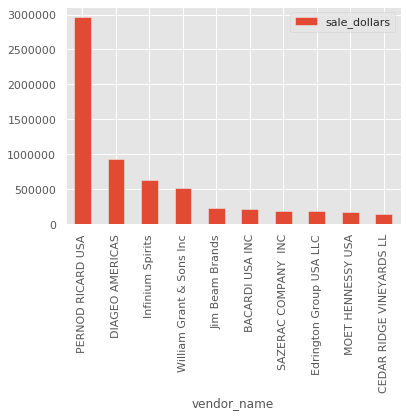

In [287]:
# Start by just plotting what we previsously grouped!
plt.style.use('ggplot')
plt.figure(figsize=(20,10))
sales_rate = dfsdol.sort_values(by='sale_dollars', ascending=False).head(10)
ax = sales_rate.plot(kind='bar')

<Figure size 1440x720 with 0 Axes>

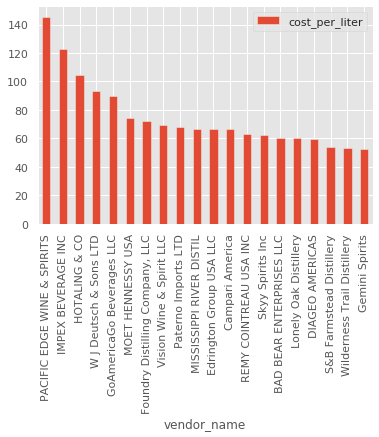

In [192]:
# Start by just plotting what we previsously grouped!
plt.style.use('ggplot')
plt.figure(figsize=(20,10))
sales_rate = dfscpl.sort_values(by='cost_per_liter', ascending=False).head(20)
ax = sales_rate.plot(kind='bar')

Above are some additional plots to help you visualize a more complete dataset on cost per liter as well as sales dollar of our specific whiskeis in the study. As discussed before, the Pernod Richard whiskey is the top selling vendor,while Pacific Edge Whiskey has the highest cost per liter, ensinuating they are seeling the most valueable whiskey. 


![image.png](attachment:image.png)
If we are interested in big box retailers, lets look into Hy-Vee.

In [0]:
hv_df = pd.get_dummies(df['store_parent'], drop_first=False)

hv_df = pd.concat([df, hv_df], axis = 1, sort=False)

In [194]:
hv_df.head()

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,category,category_name,vendor_number,vendor_name,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,liquor_category,store_parent,month,year,monthyear,sale_dollars_trans,cost_per_liter,cost_per_liter_trans,CVS,Caseys,Hy-Vee,Kum&Go,Other,QuikTrip,SamsClub,SmokingJoes,Target,Wal-Mart,Walgreens
0,INV-23084400002,2019-11-07,3869,BOOTLEGGIN' BARZINI'S FIN,412 1st Ave,Coralville,52241,POINT (-91.565517 41.672672),52,JOHNSON,1.0921e+06,IMPORTED DISTILLED SPIRIT SPECIALTY,293,JINRO AMERICA INC,989215,JINRO CHAMISUL GRAPEFRUIT SOJU,20,375,3.85,5.78,20.0,115.60,7.50,1.98,Other,Other,Nov,2019,Nov-2019,4.750136,15.413333,2.735233,0,0,0,0,1,0,0,0,0,0,0
1,INV-23282200001,2019-11-18,4617,LICKETY LIQUOR,2501 HUBBELL AVE,Des Moines,50317,POINT (-93.570489 41.607817),77,POLK,1.0913e+06,NEUTRAL GRAIN SPIRITS FLAVORED,346,OLE SMOKY DISTILLERY LLC,86739,OLE SMOKY APPLE PIE MOONSHINE 70PRF MINI,8,50,8.75,13.13,1.0,13.13,0.05,0.01,Other,Other,Nov,2019,Nov-2019,2.574900,262.600000,5.570632,0,0,0,0,1,0,0,0,0,0,0
2,INV-19435800130,2019-05-17,2560,HY-VEE FOOD STORE / MARION,3600 Business Hwy 151 East,Marion,52302,blank,57,LINN,1.0421e+06,IMPORTED DRY GINS,35,BACARDI USA INC,28233,BOMBAY SAPPHIRE GIN,12,1000,16.50,24.75,6.0,148.50,6.00,1.58,GIN,Hy-Vee,May,2019,May-2019,5.000585,24.750000,3.208825,0,0,1,0,0,0,0,0,0,0,0
3,INV-23454200002,2019-11-25,2614,HY-VEE #3 FOOD & DRUGSTORE / DAVENPORT,1823 E Kimberly Rd,Davenport,52807,POINT (-90.548919 41.55678100000001),82,SCOTT,1.0113e+06,SINGLE BARREL BOURBON WHISKIES,184,FOUR ROSES DISTILLERY,18350,FOUR ROSES SINGLE BARREL,6,750,21.17,31.76,24.0,762.24,18.00,4.75,WHISKY,Hy-Vee,Nov,2019,Nov-2019,6.636261,42.346667,3.745890,0,0,1,0,0,0,0,0,0,0,0
4,INV-23541200001,2019-11-27,2629,HY-VEE FOOD STORE #2 / COUNCIL BLUFFS,1745 Madison Ave,Council Bluffs,51503,POINT (-95.825137 41.242732),78,POTTAWATTA,1.9012e+06,SPECIAL ORDER ITEMS,285,Charles Jacquin Et Cie,902291,SOOH BARTENDERS BANANAS OVER YOU,6,1750,9.31,13.97,12.0,167.64,21.00,5.54,Other,Hy-Vee,Nov,2019,Nov-2019,5.121819,7.982857,2.077296,0,0,1,0,0,0,0,0,0,0,0


In [195]:
hv_grouped = hv_df.groupby(by=['liquor_category', 'Hy-Vee']).median()
hv_grouped

pack  bottle_volume_ml  ...  Wal-Mart  Walgreens
liquor_category Hy-Vee                          ...                     
AMARETTO        0          6               750  ...         0          0
                1          6               750  ...         0          0
BRANDY          0          6               750  ...         0          0
                1         12               750  ...         0          0
GIN             0         12              1000  ...         0          0
                1         12               750  ...         0          0
LIQUEUR         0         12               750  ...         0          0
                1         12               750  ...         0          0
Other           0          6               750  ...         0          0
                1          6               750  ...         0          0
RUM             0         12               750  ...         0          0
                1         12               750  ...         0          0
SCHNAPPS        0          6              1750  ...         0          0
                1         12               875  ...         0          0
TEQUILA         0         12              1000  ...         0          0
                1         12              1000  ...         0          0
VODKA           0         12               750  ...         0          0
                1         12               750  ...         0          0
WHISKY          0         12               750  ...         0          0
                1         10               750  ...         0          0

[20 rows x 21 columns]

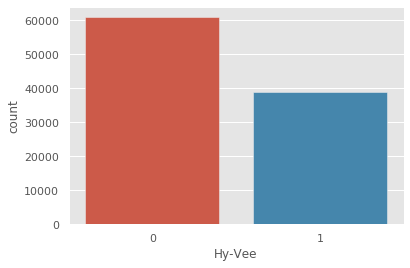

In [196]:
import seaborn as sns
cmap = sns.diverging_palette(220, 10, as_cmap=True) # one of the many color mappings
sns.countplot(x='Hy-Vee', data=hv_df);

Over 30k sales in our dataset were attributed to stores other than Hy-Vee, while the remaining 20k are from Hy-Vee

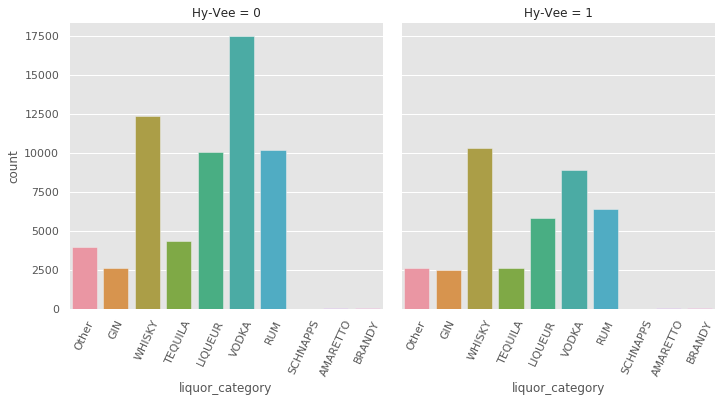

In [298]:
chart=sns.catplot(x='liquor_category', col='Hy-Vee', kind='count', data=hv_df)
chart.set_xticklabels(rotation=65, ha='center')

In [198]:
pd.crosstab(hv_df.liquor_category, hv_df['Hy-Vee'], margins=True).style.background_gradient(cmap='autumn_r')

Hy-Vee,0,1,All
liquor_category,,,
AMARETTO,39,6,45
BRANDY,13,6,19
GIN,2608,2459,5067
LIQUEUR,10064,5808,15872
Other,3960,2608,6568
RUM,10136,6410,16546
SCHNAPPS,4,2,6
TEQUILA,4316,2600,6916
VODKA,17452,8864,26316


In the two plots above, we can see the categorical sales tended to remain relatively consistent between Hy-Vee stores as opposed to other liquor stores in the area. This would suggest that Hy-Vee isn't buying liquor differently than anyone else in the state. 

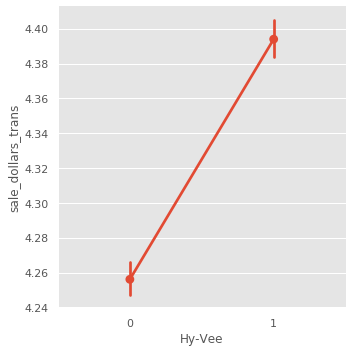

In [199]:
sns.catplot('Hy-Vee', "sale_dollars_trans", kind='point', data=hv_df)

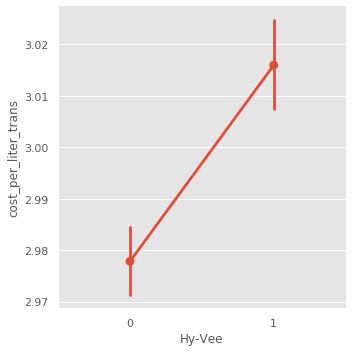

In [200]:
sns.catplot('Hy-Vee', "cost_per_liter_trans", kind='point', data=hv_df)

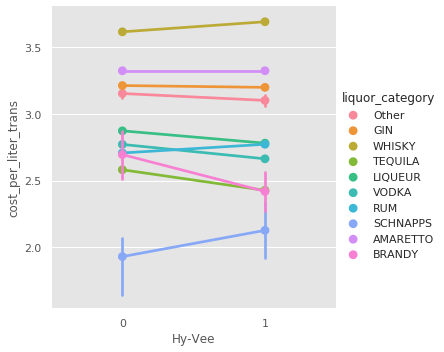

In [201]:
sns.catplot('Hy-Vee','cost_per_liter_trans',hue='liquor_category', kind='point', data=hv_df);

I was curious to see if HyVee Charged Higher Prices than the competitors. Looking at the cost per liter (which would normalize liquor cost), It appears that Hy-Vee had much higher prices. However, grouping by category, we can see that this might have been dur to the volume of whiskey sales Hy-Vee had compared to non-hy-vee stores. The costs are pretty consistent. 

Lets try this with Small Liquor stores vs large big-box stores, using the same code as above but with Other instead of Hy-Vee.

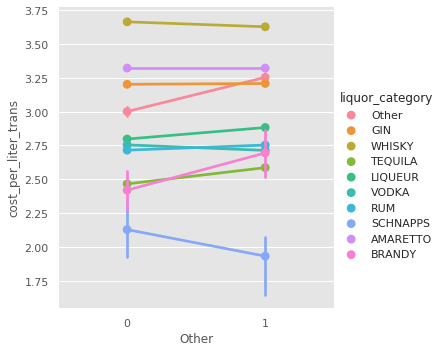

In [202]:
sns.catplot('Other','cost_per_liter_trans',hue='liquor_category', kind='point', data=hv_df);

With 0 being Big Box Stores and 1 Being Small Retailers, we can see that consistently, Small Chains are charging higher prices. 

## Explore Joint Attributes
Visualize relationships between attributes: Look at the attributes via scatter plots, correlation, cross-tabulation, group-wise averages, etc. as appropriate. Explain any interesting relationships.  

The next section dives deeper into the relationsihps between all the variables in our dataset as well as some of the key relationships found between our features. This will be a starting point for us to better understand if we can begin to think about addressing and removing highly correlated features in our set. 

To measure this, we will be able to run grid plots and heat maps with each feature against one another. The plots that are highly coorelated will be closer to 1 while the plots that are highly negatively correlated will be closer to -1. 

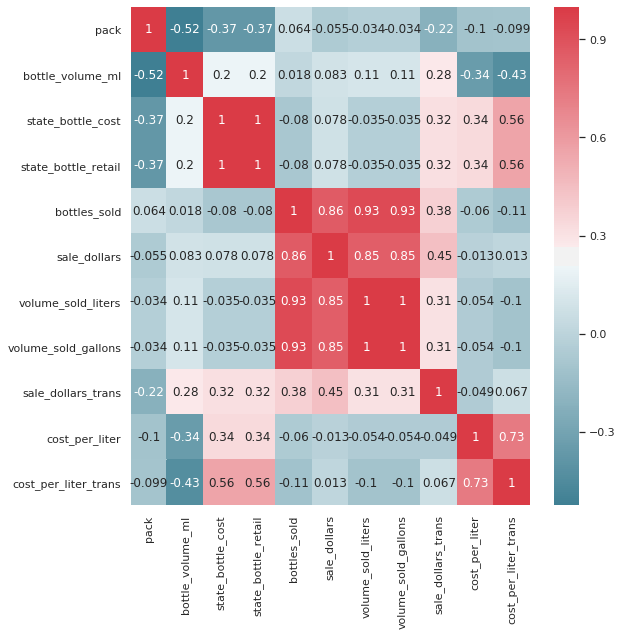

In [203]:
# plot the correlation matrix using seaborn
import seaborn as sns
cmap = sns.diverging_palette(220, 10, as_cmap=True) # one of the many color mappings

sns.set(style="darkgrid") # one of the many styles to plot using
f, ax = plt.subplots(figsize=(9, 9))
sns.heatmap(df.corr(), cmap=cmap, annot=True)
f.tight_layout()

Looking at a heat map of our coorelation plot, we can see some interesting occurances happening in the bottom right corner with regards to the volume stats as well as the sales stats. We are seeing cases of volume_sold_gallons and liters having a 0.93 coorelation to bottles sold. Which makes sense, because the greater the volume of sales would suggest the greater number of bottles in the purchase. 

In addition, these volume stats are highly correlated at 0.85 to sale dollars. While this is expected as it costs more to get more whiskey, it's interesting as there tends to be somewhwat of a minimal affect with regards to volume discounts. 

In [204]:
df

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,category,category_name,vendor_number,vendor_name,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,liquor_category,store_parent,month,year,monthyear,sale_dollars_trans,cost_per_liter,cost_per_liter_trans
0,INV-23084400002,2019-11-07,3869,BOOTLEGGIN' BARZINI'S FIN,412 1st Ave,Coralville,52241,POINT (-91.565517 41.672672),52,JOHNSON,1.0921e+06,IMPORTED DISTILLED SPIRIT SPECIALTY,293,JINRO AMERICA INC,989215,JINRO CHAMISUL GRAPEFRUIT SOJU,20,375,3.85,5.78,20.0,115.60,7.50,1.98,Other,Other,Nov,2019,Nov-2019,4.750136,15.413333,2.735233
1,INV-23282200001,2019-11-18,4617,LICKETY LIQUOR,2501 HUBBELL AVE,Des Moines,50317,POINT (-93.570489 41.607817),77,POLK,1.0913e+06,NEUTRAL GRAIN SPIRITS FLAVORED,346,OLE SMOKY DISTILLERY LLC,86739,OLE SMOKY APPLE PIE MOONSHINE 70PRF MINI,8,50,8.75,13.13,1.0,13.13,0.05,0.01,Other,Other,Nov,2019,Nov-2019,2.574900,262.600000,5.570632
2,INV-19435800130,2019-05-17,2560,HY-VEE FOOD STORE / MARION,3600 Business Hwy 151 East,Marion,52302,blank,57,LINN,1.0421e+06,IMPORTED DRY GINS,35,BACARDI USA INC,28233,BOMBAY SAPPHIRE GIN,12,1000,16.50,24.75,6.0,148.50,6.00,1.58,GIN,Hy-Vee,May,2019,May-2019,5.000585,24.750000,3.208825
3,INV-23454200002,2019-11-25,2614,HY-VEE #3 FOOD & DRUGSTORE / DAVENPORT,1823 E Kimberly Rd,Davenport,52807,POINT (-90.548919 41.55678100000001),82,SCOTT,1.0113e+06,SINGLE BARREL BOURBON WHISKIES,184,FOUR ROSES DISTILLERY,18350,FOUR ROSES SINGLE BARREL,6,750,21.17,31.76,24.0,762.24,18.00,4.75,WHISKY,Hy-Vee,Nov,2019,Nov-2019,6.636261,42.346667,3.745890
4,INV-23541200001,2019-11-27,2629,HY-VEE FOOD STORE #2 / COUNCIL BLUFFS,1745 Madison Ave,Council Bluffs,51503,POINT (-95.825137 41.242732),78,POTTAWATTA,1.9012e+06,SPECIAL ORDER ITEMS,285,Charles Jacquin Et Cie,902291,SOOH BARTENDERS BANANAS OVER YOU,6,1750,9.31,13.97,12.0,167.64,21.00,5.54,Other,Hy-Vee,Nov,2019,Nov-2019,5.121819,7.982857,2.077296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,INV-22219300036,2019-09-30,3776,WAL-MART 5115 / DAVENPORT,3101 West Kimberly Rd,Davenport,52806,POINT (-90.620069 41.559268),82,SCOTT,1.0221e+06,MIXTO TEQUILA,434,LUXCO INC,89387,JUAREZ TEQUILA GOLD,12,1000,7.83,11.75,12.0,141.00,12.00,3.17,TEQUILA,Wal-Mart,Sep,2019,Sep-2019,4.948760,11.750000,2.463853
99996,INV-22567100020,2019-10-15,5351,DOWNTOWN LIQUOR,1203 5th St.,Sioux City,51101,POINT (-96.394671 42.495324),97,WOODBURY,1.0221e+06,MIXTO TEQUILA,434,LUXCO INC,89387,JUAREZ GOLD,12,1000,7.83,11.75,12.0,141.00,12.00,3.17,TEQUILA,Other,Oct,2019,Oct-2019,4.948760,11.750000,2.463853
99997,INV-22471800013,2019-10-11,2607,HY-VEE WINE AND SPIRITS / SHENANDOAH,520 So Fremont,Shenandoah,51601,POINT (-95.385111 40.761736),73,PAGE,1.0221e+06,MIXTO TEQUILA,434,LUXCO INC,89387,JUAREZ GOLD,12,1000,7.83,11.75,12.0,141.00,12.00,3.17,TEQUILA,Hy-Vee,Oct,2019,Oct-2019,4.948760,11.750000,2.463853
99998,INV-22549300142,2019-10-15,2651,HY-VEE / WAVERLY,1311 4 Street SW,Waverly,50677,POINT (-92.475403 42.712263),9,BREMER,1.0221e+06,MIXTO TEQUILA,434,LUXCO INC,89387,JUAREZ GOLD,12,1000,7.83,11.75,12.0,141.00,12.00,3.17,TEQUILA,Hy-Vee,Oct,2019,Oct-2019,4.948760,11.750000,2.463853


In [0]:
# now try plotting some of the previous plots, way more visually appealing!!
#https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166
import seaborn as sns

sns.set(style="darkgrid") # one of the many styles to plot using


In [206]:
dfenc.dtypes
df.dtypes

invoice_and_item_number     object
date                        object
store_number                object
store_name                  object
address                     object
city                        object
zip_code                    object
store_location              object
county_number               object
county                      object
category                    object
category_name               object
vendor_number               object
vendor_name                 object
item_number                 object
item_description            object
pack                         int64
bottle_volume_ml             int64
state_bottle_cost          float64
state_bottle_retail        float64
bottles_sold               float64
sale_dollars               float64
volume_sold_liters         float64
volume_sold_gallons        float64
liquor_category             object
store_parent                object
month                       object
year                        object
monthyear           

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


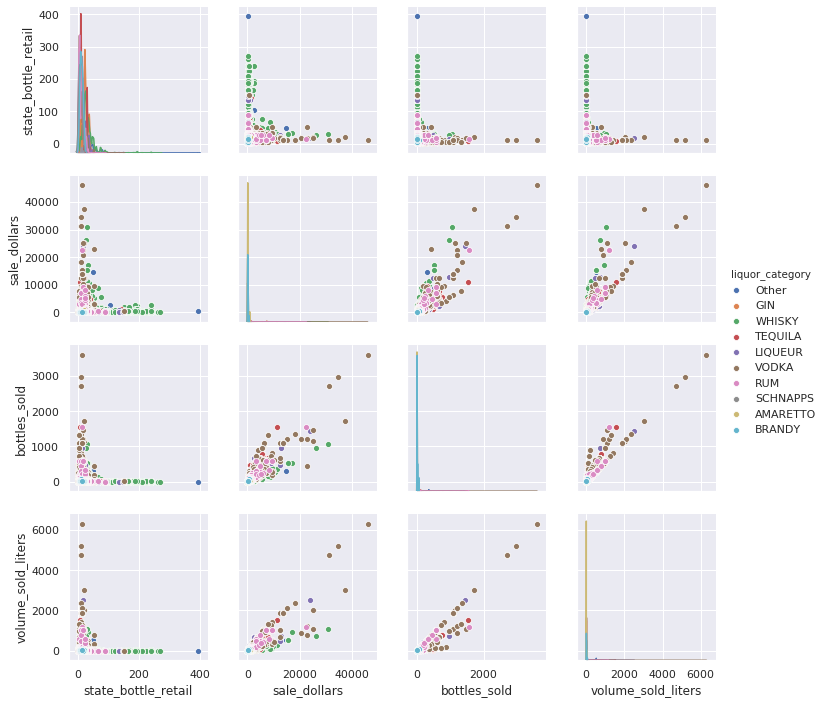

In [207]:
sns.pairplot(dfenc, hue= 'liquor_category', vars = ['state_bottle_retail', 'sale_dollars', 'bottles_sold', 'volume_sold_liters'])

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


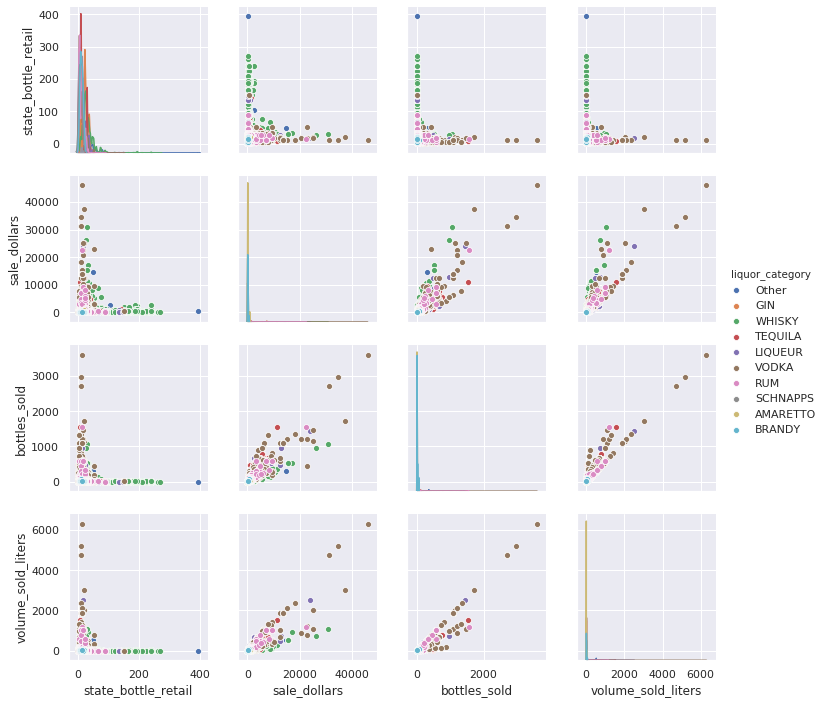

In [208]:
sns.pairplot(dfenc, hue= 'liquor_category', vars = ['state_bottle_retail', 'sale_dollars', 'bottles_sold', 'volume_sold_liters'], diag_kind = 'kde')

Here we can see a couple pair scatter plots that show our coorelations in action. In the bottom right corner, we can see those same highly correlated values visualized in a plot, and broken out by drink type.

Interestingly, we can see some clustering start to appear in some of the relationships, particularly between tequila and whiskey as it relates to volume sold and sales data.

![image.png](attachment:image.png)

In [209]:
#cross tab example
dfcross = pd.crosstab(df['liquor_category'], df['store_parent'],  margins=True, margins_name="Total")
dfcross

store_parent,CVS,Caseys,Hy-Vee,Kum&Go,Other,QuikTrip,SamsClub,SmokingJoes,Target,Wal-Mart,Walgreens,Total
liquor_category,,,,,,,,,,,,
AMARETTO,0,0,6,0,23,0,2,0,14,0,0,45
BRANDY,0,0,6,0,13,0,0,0,0,0,0,19
GIN,16,76,2459,0,2182,13,154,11,58,97,1,5067
LIQUEUR,10,367,5808,203,7675,165,421,267,99,811,46,15872
Other,0,46,2608,9,3391,16,90,21,47,339,1,6568
RUM,21,588,6410,33,7349,204,232,321,72,1265,51,16546
SCHNAPPS,0,0,2,0,4,0,0,0,0,0,0,6
TEQUILA,17,52,2600,7,3306,112,208,92,59,437,26,6916
VODKA,115,852,8864,818,12655,582,470,641,202,946,171,26316


Next, we are going to look at a cross tab and explore the relationships with alcohol type and store.

As you can see in the table above, Hy Vee and Other take up the majority of sales, however Other is a stronger Vodka seller while Hyvee sales more whieksy. This is confirmed below with our chart that shows the mix of alcohol sales int he story. For each, Vodka and whiskey are among the top sellers. 

In [210]:
#Normalized Cross Tab
dfcrossnorm = pd.crosstab(df['liquor_category'], df['store_parent'], normalize='columns')
dfcrossnorm

store_parent,CVS,Caseys,Hy-Vee,Kum&Go,Other,QuikTrip,SamsClub,SmokingJoes,Target,Wal-Mart,Walgreens
liquor_category,,,,,,,,,,,
AMARETTO,0.000,0.000000,0.000154,0.000000,0.000492,0.000000,0.000974,0.000000,0.016607,0.000000,0.000000
BRANDY,0.000,0.000000,0.000154,0.000000,0.000278,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
GIN,0.064,0.034250,0.062937,0.000000,0.046631,0.011140,0.075012,0.007539,0.068802,0.021356,0.002646
LIQUEUR,0.040,0.165390,0.148652,0.165714,0.164020,0.141388,0.205066,0.183002,0.117438,0.178556,0.121693
Other,0.000,0.020730,0.066750,0.007347,0.072468,0.013710,0.043838,0.014393,0.055753,0.074637,0.002646
RUM,0.084,0.264984,0.164060,0.026939,0.157053,0.174807,0.113005,0.220014,0.085409,0.278512,0.134921
SCHNAPPS,0.000,0.000000,0.000051,0.000000,0.000085,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
TEQUILA,0.068,0.023434,0.066546,0.005714,0.070652,0.095973,0.101315,0.063057,0.069988,0.096213,0.068783
VODKA,0.460,0.383957,0.226869,0.667755,0.270446,0.498715,0.228933,0.439342,0.239620,0.208278,0.452381


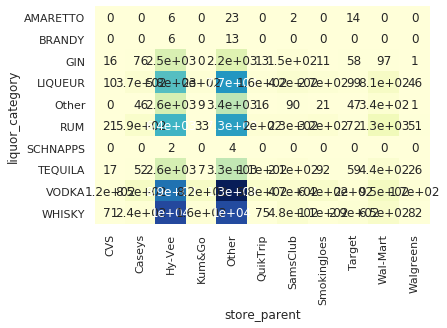

In [211]:
sns.heatmap(pd.crosstab([df['liquor_category']], [df['store_parent']]),
            cmap="YlGnBu", annot=True, cbar=False)

Next is a heatmap which shows the relationship between Vodka and Whiskey amontst the stores, which provides a visual representaiton of the data above. 

In [212]:
#group wise average
df_grouped = df.groupby(by=['liquor_category', 'store_parent']).mean()
df_grouped

pack  ...  cost_per_liter_trans
liquor_category store_parent             ...                      
AMARETTO        Hy-Vee         6.000000  ...              3.322154
                Other          6.000000  ...              3.322154
                SamsClub       6.000000  ...              3.322154
                Target         6.000000  ...              3.322154
BRANDY          Hy-Vee        12.000000  ...              2.418763
...                                 ...  ...                   ...
WHISKY          SamsClub       9.644958  ...              3.632805
                SmokingJoes   13.471698  ...              3.749201
                Target         7.952055  ...              3.691219
                Wal-Mart       8.803709  ...              3.448284
                Walgreens      9.536585  ...              3.577408

[83 rows x 11 columns]

## Explore Attributes and Class
Identify and explain interesting relationships between features and the class you are trying to predict (i.e., relationships with variables and the target classification).



## New Features 
Are there other features that could be added to the data or created from existing features? Which ones?



* Day of the week  
* education  
* median population  
* income groups  
* age groups  
* employment  
* Grouping of Liquor Brands  

We also created a series of columns which were aggregates of other columns:

* Cost Per Liter
* Total Cost
* Revenue 
* Gross Margin
* Log Transform of Sales
* Log Transform of Volume Sold

## Exceptional Work 
You have free reign to provide additional analyses. One idea: implement dimensionality reduction, then visualize and interpret the results.

### Note
Registered for credentials with Google Cloud and Big Query to be able to query our database and data frame from 17 million datapoints for analysis on our project. 

In our Visualize Attributes section, we went into a deep dive on the analysis of whiskey as well as Hy-Vee to understand their effect on the dataset. 

### Remove highly correlated features

In [0]:
df_corr = df.copy()

In [214]:
df_corr

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,category,category_name,vendor_number,vendor_name,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,liquor_category,store_parent,month,year,monthyear,sale_dollars_trans,cost_per_liter,cost_per_liter_trans
0,INV-23084400002,2019-11-07,3869,BOOTLEGGIN' BARZINI'S FIN,412 1st Ave,Coralville,52241,POINT (-91.565517 41.672672),52,JOHNSON,1.0921e+06,IMPORTED DISTILLED SPIRIT SPECIALTY,293,JINRO AMERICA INC,989215,JINRO CHAMISUL GRAPEFRUIT SOJU,20,375,3.85,5.78,20.0,115.60,7.50,1.98,Other,Other,Nov,2019,Nov-2019,4.750136,15.413333,2.735233
1,INV-23282200001,2019-11-18,4617,LICKETY LIQUOR,2501 HUBBELL AVE,Des Moines,50317,POINT (-93.570489 41.607817),77,POLK,1.0913e+06,NEUTRAL GRAIN SPIRITS FLAVORED,346,OLE SMOKY DISTILLERY LLC,86739,OLE SMOKY APPLE PIE MOONSHINE 70PRF MINI,8,50,8.75,13.13,1.0,13.13,0.05,0.01,Other,Other,Nov,2019,Nov-2019,2.574900,262.600000,5.570632
2,INV-19435800130,2019-05-17,2560,HY-VEE FOOD STORE / MARION,3600 Business Hwy 151 East,Marion,52302,blank,57,LINN,1.0421e+06,IMPORTED DRY GINS,35,BACARDI USA INC,28233,BOMBAY SAPPHIRE GIN,12,1000,16.50,24.75,6.0,148.50,6.00,1.58,GIN,Hy-Vee,May,2019,May-2019,5.000585,24.750000,3.208825
3,INV-23454200002,2019-11-25,2614,HY-VEE #3 FOOD & DRUGSTORE / DAVENPORT,1823 E Kimberly Rd,Davenport,52807,POINT (-90.548919 41.55678100000001),82,SCOTT,1.0113e+06,SINGLE BARREL BOURBON WHISKIES,184,FOUR ROSES DISTILLERY,18350,FOUR ROSES SINGLE BARREL,6,750,21.17,31.76,24.0,762.24,18.00,4.75,WHISKY,Hy-Vee,Nov,2019,Nov-2019,6.636261,42.346667,3.745890
4,INV-23541200001,2019-11-27,2629,HY-VEE FOOD STORE #2 / COUNCIL BLUFFS,1745 Madison Ave,Council Bluffs,51503,POINT (-95.825137 41.242732),78,POTTAWATTA,1.9012e+06,SPECIAL ORDER ITEMS,285,Charles Jacquin Et Cie,902291,SOOH BARTENDERS BANANAS OVER YOU,6,1750,9.31,13.97,12.0,167.64,21.00,5.54,Other,Hy-Vee,Nov,2019,Nov-2019,5.121819,7.982857,2.077296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,INV-22219300036,2019-09-30,3776,WAL-MART 5115 / DAVENPORT,3101 West Kimberly Rd,Davenport,52806,POINT (-90.620069 41.559268),82,SCOTT,1.0221e+06,MIXTO TEQUILA,434,LUXCO INC,89387,JUAREZ TEQUILA GOLD,12,1000,7.83,11.75,12.0,141.00,12.00,3.17,TEQUILA,Wal-Mart,Sep,2019,Sep-2019,4.948760,11.750000,2.463853
99996,INV-22567100020,2019-10-15,5351,DOWNTOWN LIQUOR,1203 5th St.,Sioux City,51101,POINT (-96.394671 42.495324),97,WOODBURY,1.0221e+06,MIXTO TEQUILA,434,LUXCO INC,89387,JUAREZ GOLD,12,1000,7.83,11.75,12.0,141.00,12.00,3.17,TEQUILA,Other,Oct,2019,Oct-2019,4.948760,11.750000,2.463853
99997,INV-22471800013,2019-10-11,2607,HY-VEE WINE AND SPIRITS / SHENANDOAH,520 So Fremont,Shenandoah,51601,POINT (-95.385111 40.761736),73,PAGE,1.0221e+06,MIXTO TEQUILA,434,LUXCO INC,89387,JUAREZ GOLD,12,1000,7.83,11.75,12.0,141.00,12.00,3.17,TEQUILA,Hy-Vee,Oct,2019,Oct-2019,4.948760,11.750000,2.463853
99998,INV-22549300142,2019-10-15,2651,HY-VEE / WAVERLY,1311 4 Street SW,Waverly,50677,POINT (-92.475403 42.712263),9,BREMER,1.0221e+06,MIXTO TEQUILA,434,LUXCO INC,89387,JUAREZ GOLD,12,1000,7.83,11.75,12.0,141.00,12.00,3.17,TEQUILA,Hy-Vee,Oct,2019,Oct-2019,4.948760,11.750000,2.463853


In [215]:
df_corr.head()

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,category,category_name,vendor_number,vendor_name,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,liquor_category,store_parent,month,year,monthyear,sale_dollars_trans,cost_per_liter,cost_per_liter_trans
0,INV-23084400002,2019-11-07,3869,BOOTLEGGIN' BARZINI'S FIN,412 1st Ave,Coralville,52241,POINT (-91.565517 41.672672),52,JOHNSON,1.0921e+06,IMPORTED DISTILLED SPIRIT SPECIALTY,293,JINRO AMERICA INC,989215,JINRO CHAMISUL GRAPEFRUIT SOJU,20,375,3.85,5.78,20.0,115.60,7.50,1.98,Other,Other,Nov,2019,Nov-2019,4.750136,15.413333,2.735233
1,INV-23282200001,2019-11-18,4617,LICKETY LIQUOR,2501 HUBBELL AVE,Des Moines,50317,POINT (-93.570489 41.607817),77,POLK,1.0913e+06,NEUTRAL GRAIN SPIRITS FLAVORED,346,OLE SMOKY DISTILLERY LLC,86739,OLE SMOKY APPLE PIE MOONSHINE 70PRF MINI,8,50,8.75,13.13,1.0,13.13,0.05,0.01,Other,Other,Nov,2019,Nov-2019,2.574900,262.600000,5.570632
2,INV-19435800130,2019-05-17,2560,HY-VEE FOOD STORE / MARION,3600 Business Hwy 151 East,Marion,52302,blank,57,LINN,1.0421e+06,IMPORTED DRY GINS,35,BACARDI USA INC,28233,BOMBAY SAPPHIRE GIN,12,1000,16.50,24.75,6.0,148.50,6.00,1.58,GIN,Hy-Vee,May,2019,May-2019,5.000585,24.750000,3.208825
3,INV-23454200002,2019-11-25,2614,HY-VEE #3 FOOD & DRUGSTORE / DAVENPORT,1823 E Kimberly Rd,Davenport,52807,POINT (-90.548919 41.55678100000001),82,SCOTT,1.0113e+06,SINGLE BARREL BOURBON WHISKIES,184,FOUR ROSES DISTILLERY,18350,FOUR ROSES SINGLE BARREL,6,750,21.17,31.76,24.0,762.24,18.00,4.75,WHISKY,Hy-Vee,Nov,2019,Nov-2019,6.636261,42.346667,3.745890
4,INV-23541200001,2019-11-27,2629,HY-VEE FOOD STORE #2 / COUNCIL BLUFFS,1745 Madison Ave,Council Bluffs,51503,POINT (-95.825137 41.242732),78,POTTAWATTA,1.9012e+06,SPECIAL ORDER ITEMS,285,Charles Jacquin Et Cie,902291,SOOH BARTENDERS BANANAS OVER YOU,6,1750,9.31,13.97,12.0,167.64,21.00,5.54,Other,Hy-Vee,Nov,2019,Nov-2019,5.121819,7.982857,2.077296


In [216]:
import pandas as pd
import numpy as np

# Create correlation matrix

corr_matrix = df_corr.corr().abs()
corr_matrix

,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,sale_dollars_trans,cost_per_liter,cost_per_liter_trans
pack,1.000000,0.524984,0.372595,0.372605,0.063851,0.054947,0.033874,0.033878,0.220555,0.104393,0.099069
bottle_volume_ml,0.524984,1.000000,0.198027,0.198021,0.018185,0.083270,0.105215,0.105266,0.278621,0.341817,0.433075
state_bottle_cost,0.372595,0.198027,1.000000,0.999997,0.079659,0.077954,0.034642,0.034672,0.316767,0.336962,0.559542
state_bottle_retail,0.372605,0.198021,0.999997,1.000000,0.079656,0.077957,0.034640,0.034670,0.316782,0.336955,0.559545
bottles_sold,0.063851,0.018185,0.079659,0.079656,1.000000,0.860335,0.933128,0.933131,0.376807,0.059543,0.109417
sale_dollars,0.054947,0.083270,0.077954,0.077957,0.860335,1.000000,0.849849,0.849848,0.451366,0.012803,0.013049
volume_sold_liters,0.033874,0.105215,0.034642,0.034640,0.933128,0.849849,1.000000,1.000000,0.305803,0.054176,0.104422
volume_sold_gallons,0.033878,0.105266,0.034672,0.034670,0.933131,0.849848,1.000000,1.000000,0.305826,0.054192,0.104479
sale_dollars_trans,0.220555,0.278621,0.316767,0.316782,0.376807,0.451366,0.305803,0.305826,1.000000,0.048572,0.066561
cost_per_liter,0.104393,0.341817,0.336962,0.336955,0.059543,0.012803,0.054176,0.054192,0.048572,1.000000,0.732996


In [0]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# courtesy of https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/

In [218]:
to_drop

['state_bottle_retail', 'volume_sold_gallons']

Looking at our correlation matrix, we can deem that per our criteria of removing features that have a greater than 95% correlation. As the predictability of one feature will detirmine another, which will cause us to want to do a dimensionality reduction. 
In our case, we are going to remove state_bottle_retail as it correlates highly with state_bottle_cost, as well as volume_sold_gallons as it correlates perfectly with volume_sold_liters.

In [0]:
# Drop features 
df_corr = df_corr.drop(df_corr[to_drop], axis=1)

PCA
To run a PCA analysis, we will want to first remove some of the highly correlated variables which may throw off our analysis. This will mean we should run a correlation plot and set our correlation threshold to 0.95, which we will remove variables if we exceed. 

First lets take a look at our seaborn plot that we will use to run principal component analysis. To get started, we will want to create dummies for each of our categories of alcohol, so that we have a single binary under Whiskey as the sale was a whiskey drink (1) or it was not (0)

In [0]:
df_corr2 = pd.get_dummies(df['liquor_category'], drop_first=False)

df_corr = pd.concat([df_corr, df_corr2], axis = 1, sort=False)

In [221]:
# now let's use PCA, and LDA to find the two "best" dimensions of this data
# these are linear transforms to help project the features into something more understandable

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

#drop the response variable from x
# one hot encoding to category
features = ['pack', 'bottle_volume_ml', 'state_bottle_cost', 'bottles_sold', 'sale_dollars_trans', 'volume_sold_liters']

X = df_corr.loc[:, features].values
# run this second line below which compiles all the features that i want to use to predict category, or the column we want to predict
#X = X.drop (category, inplace = True)
y = df_corr.loc[:, ['WHISKY']].values
#target_names = df_corr.store_parent_names

pca = PCA(n_components=2)
X_pca = pca.fit(X).transform(X) # fit data and then transform it

lda = LDA(n_components=2)
X_lda = lda.fit(X, y).transform(X) # fit data and then transform it

# print the components

print ('pca:', pca.components_)
print ('lda:', lda.scalings_.T)

pca: [[-9.96268327e-03  9.99854583e-01  4.78344366e-03  1.74466426e-03
   6.81414654e-04  1.28518020e-02]
 [ 5.44274601e-03 -1.13278677e-02 -1.13080076e-02  5.86380977e-01
   5.23715486e-03  8.09842026e-01]]
lda: [[-0.02220356 -0.00111863  0.0914088  -0.0063875   0.19137608  0.00305548]]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:463: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(6, 2 - 1) = 1 components.
  ChangedBehaviorWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:469: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)


Now what we did here was isolate our categorical variable "Whiskey" and fit a pca and LDA model using the continuous variables remaining in the set. Using this, our model will be able to advise on how much we can explain variance using the different principal components. 
Scaling it in this way allows our model to utilize and compare all variables on the same plane. 

In [222]:
principalDf = pd.DataFrame(data = X_pca
             , columns = ['principal component 1', 'principal component 2'])

principalDf.describe()

,principal component 1,principal component 2
count,1.000000e+05,1.000000e+05
mean,-4.119019e-13,-7.528535e-14
std,4.651228e+02,6.813634e+01
min,-8.230081e+02,-6.859997e+01
25%,-1.230155e+02,-1.230450e+01
50%,-1.228773e+02,-6.612062e+00
75%,1.270925e+02,4.784553e-01
max,5.127167e+03,7.188155e+03


creating a dataframe of our principal components, we can see that there is quite a range in the values we have, from the negatives to the positives, with also a strong standard deviation. 
The mean principal component is nearly off the scale due to the effect of outliers. 

In [223]:
finalDf = pd.concat([principalDf, df_corr[['WHISKY']]], axis = 1)

finalDf.head()

,principal component 1,principal component 2,WHISKY
0,-497.959409,8.653345,0
1,-822.899534,-4.971774,0
2,127.046385,-8.035946,0
3,-122.648405,14.992085,1
4,877.166033,-0.816647,0


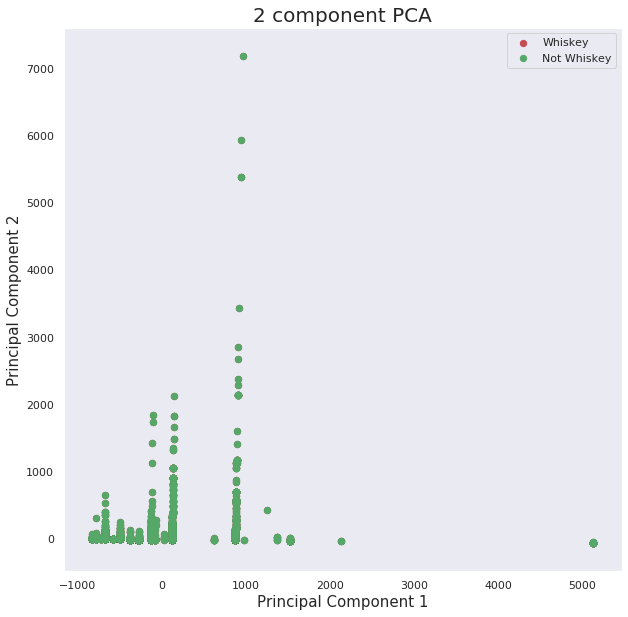

In [224]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Whiskey', 'Not Whiskey']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['WHISKY'] == 0
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 40)
ax.legend(targets)
ax.grid()

Looking at the plot we graphed, we can see the effect of outliers and the fact that non/whiskies have quite a presence in our chart. 
Our explained variance ratio below shows that we can explain 97% of the variance with one principal component, and less than 3% with the second principal component.

In [225]:
pca.explained_variance_ratio_

array([0.97759309, 0.02097879])

In [226]:
#lets transform our outliers to make them easier to read. 

finalDf2 = finalDf

finalDf2['principal component 1 trans'] = np.log(finalDf['principal component 1'])
finalDf2['principal component 2 trans'] = np.log(finalDf['principal component 2'])

finalDf2.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:856: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,principal component 1,principal component 2,WHISKY,principal component 1 trans,principal component 2 trans
0,-497.959409,8.653345,0,NaN,2.157946
1,-822.899534,-4.971774,0,NaN,NaN
2,127.046385,-8.035946,0,4.844552,NaN
3,-122.648405,14.992085,1,NaN,2.707522
4,877.166033,-0.816647,0,6.776696,NaN


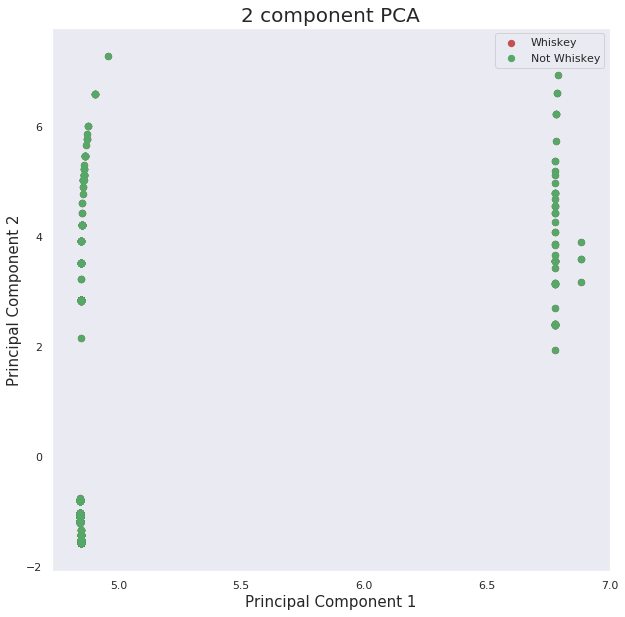

In [227]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Whiskey', 'Not Whiskey']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf2['WHISKY'] == 1
    ax.scatter(finalDf2.loc[indicesToKeep, 'principal component 1 trans']
               , finalDf2.loc[indicesToKeep, 'principal component 2 trans']
               , c = color
               , s = 40)
ax.legend(targets)
ax.grid()

To make our chart easier to read, i decided to take a transform of our principal components to normalize their distribution. As you can see, their values separate a lot more in our dataset. However, the non whiskey values play a small presence.

### Ascertain Data from BigQuery

Because the dataset is so large, 17.7 million rows and over 4GB in size, we couldn't pull the entire dataset from BigQuery into Pandas.  

So, initial analysis of the entire dataset was done by querying BigQuery

First needed to connect to BigQuery, then do a some EDA against the data set by querying BigQuery and visualize those results to determine a good subset of the data.

In [228]:
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
project_id = 'smu-7331-ml'

plt.rc('axes', axisbelow=True)

# Imports the Google Cloud client library
#from google.cloud import bigquery
# Instantiates a client for BigQuery Service
#bqclient = bigquery.Client()

from google.colab import auth
auth.authenticate_user()
print('Authenticated')

from google.cloud import bigquery
bqclient = bigquery.Client(project=project_id)


Authenticated


#### Functions

##### Execute Query

In [0]:
def execute_query(QUERY):
    # Run the query and get data from BQ
    query_job = bqclient.query(QUERY)
    return query_job.to_dataframe()

#### Exploratory Data Analysis

##### Total data size and column types

In [230]:
QUERY="""
    SELECT
        count(*) as TotalRows
    FROM `bigquery-public-data.iowa_liquor_sales.sales`
"""
df=execute_query(QUERY)
df

,TotalRows
0,17735173


##### Get Columns and Data Types for Columns

In [231]:
QUERY="""
    SELECT
        *
    FROM `bigquery-public-data.iowa_liquor_sales.sales`
    LIMIT 10
"""
df=execute_query(QUERY)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 24 columns):
invoice_and_item_number    10 non-null object
date                       10 non-null object
store_number               10 non-null object
store_name                 10 non-null object
address                    10 non-null object
city                       10 non-null object
zip_code                   10 non-null object
store_location             10 non-null object
county_number              10 non-null object
county                     10 non-null object
category                   10 non-null object
category_name              10 non-null object
vendor_number              10 non-null object
vendor_name                10 non-null object
item_number                10 non-null object
item_description           10 non-null object
pack                       10 non-null int64
bottle_volume_ml           10 non-null int64
state_bottle_cost          10 non-null float64
state_bottle_retail      

In [232]:
pd.set_option('display.max_columns', None)
df.head()

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,category,category_name,vendor_number,vendor_name,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons
0,INV-08269700125,2017-10-26,5102,Wilkie Liquors,724 1st St SE,Mount Vernon,52314,POINT (-91.410401 41.918328),57,LINN,1062300,Aged Dark Rum,460,Shaw-Ross International,44266,British Navy Pusser's Rum,6,750,12.02,18.03,18,324.54,13.5,3.57
1,S08774900041,2012-11-06,3952,Lot-A-Spirits,3780 STATE ST,BETTENDORF,52722,POINT (-90.48065 41.529655),82,Scott,1081317,GRAPE SCHNAPPS,65,Jim Beam Brands,82637,Dekuyper Grape Pucker,12,1000,7.35,11.02,84,925.68,84.0,22.19
2,S13126400077,2013-07-02,4312,I-80 Liquor / Council Bluffs,2411 S 24TH ST #1,COUNCIL BLUFFS,51501,POINT (-95.8792 41.238092),78,Pottawattamie,1081312,BUTTERSCOTCH SCHNAPPS,65,Jim Beam Brands,82787,Dekuyper Buttershots,12,1000,7.62,11.43,8,91.44,8.0,2.11
3,S32801600011,2016-06-13,4024,Wal-Mart 1546 / Iowa Falls,840 S Oak,Iowa Falls,50126,POINT (-93.262446 42.503407),42,Hardin,1701100,DECANTERS & SPECIALTY PACKAGES,260,Diageo Americas,183,Smirnoff 1.75L Glass w/2-50mls,6,1850,14.75,22.13,6,132.78,11.1,2.93
4,S32909400205,2016-06-16,2633,Hy-Vee #3 / BDI / Des Moines,3221 SE 14th St,Des Moines,50320,POINT (-93.596754 41.554101),77,Polk,1081330,PEACH SCHNAPPS,65,Jim Beam Brands,82847,Dekuyper Peachtree,12,1000,7.87,11.81,84,992.04,84.0,22.19


##### Look at distribution of data for each Year-Month

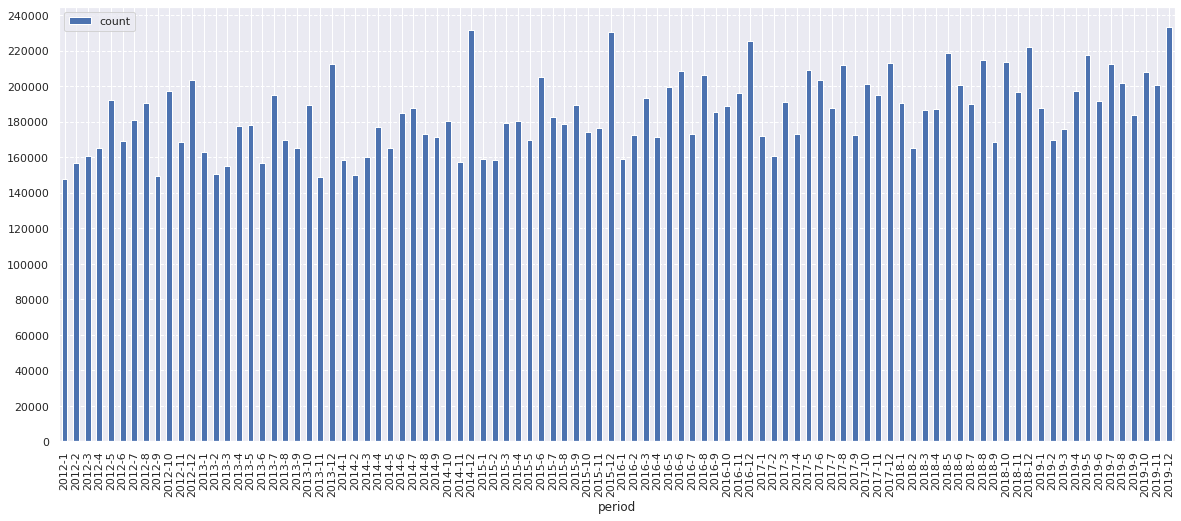

In [233]:
# How many rows of data for each month for each year 
QUERY="""
SELECT
    extract(YEAR from date) as year,
    extract(MONTH from date) as month,
    count(*) as count
FROM `bigquery-public-data.iowa_liquor_sales.sales`
group by year, month
order by year, month
"""
df = execute_query(QUERY)

# Plot the results
df['period'] = df['year'].map(str) +'-' +df['month'].map(str)
#df.groupby(['year', 'month'])['count'].sum().plot(kind='bar', figsize=(20, 8))
plot=df.plot(kind='bar', x='period', y='count', figsize=(20,8))
#xtick = pd.date_range( start=ts.index.min( ), end=ts.index.max( ), freq='W' )
#plot.set_xticks( xtick, minor=True )
#plot.grid('off', which='minor', axis='y' )
plot.grid('on', axis='y', linestyle='dashed')
plt.yticks(np.arange(0, max(df['count']+10000), 20000))
plt.show()

##### Determine the different liquor categories

In [234]:
# How many rows of data for each month for each year 
QUERY="""
SELECT
    category_name,
    count(*) as count
FROM `bigquery-public-data.iowa_liquor_sales.sales`
group by category_name
order by category_name
"""
df = execute_query(QUERY)
df

,category_name,count
0,None,24358
1,100 PROOF VODKA,99124
2,100% Agave Tequila,205653
3,AMARETTO - IMPORTED,102
4,AMERICAN ALCOHOL,24351
...,...,...
125,WHISKEY LIQUEUR,334572
126,WHITE CREME DE CACAO,7213
127,WHITE CREME DE MENTHE,2459
128,Whiskey Liqueur,367183


##### Group vodka, rum, whiskey, tequila as separate categories, and everything else as other

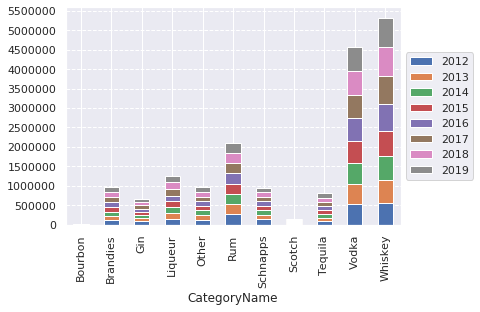

In [235]:
QUERY="""
SELECT
CASE
  WHEN lower(category_name) like '%rum%' then 'Rum'
  WHEN lower(category_name) like '%whisk%' then 'Whiskey'
  WHEN lower(category_name) like '%vodka%' then 'Vodka'
  WHEN lower(category_name) like '%tequila%' then 'Tequila'
  WHEN lower(category_name) like '%schnapps%' then 'Schnapps'
  WHEN lower(category_name) like '%gin%' then 'Gin'
  WHEN lower(category_name) like '%bourbon%' then 'Bourbon'
  WHEN lower(category_name) like '%brandies%' then 'Brandies'
  WHEN lower(category_name) like '%liqueur%' then 'Liqueur'
  WHEN lower(category_name) like '%scotch%' then 'Scotch'
  ELSE 'Other'
END
as CategoryName,
extract(Year from date) as Year,
extract(month from date) as Month,
count(*) as Count
FROM
  `bigquery-public-data.iowa_liquor_sales.sales`
group by year, month, categoryname
order by year, month, CategoryName
"""
df = execute_query(QUERY)
catYear=df.groupby(['CategoryName', 'Year'])['Count'].sum().unstack().plot(kind='bar', stacked=True)
catYear.grid('on', axis='y', linestyle='dashed')
plt.yticks(np.arange(0, 6000000, 500000))
plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

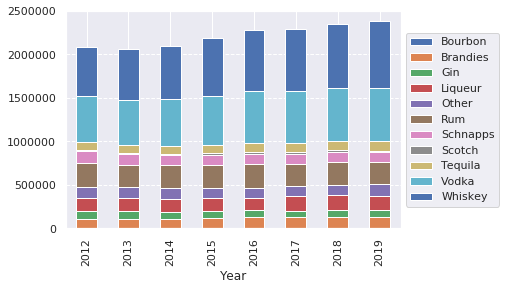

In [236]:
yearCat=df.groupby(['Year', 'CategoryName'])['Count'].sum().unstack().plot(kind='bar', stacked=True)
yearCat.grid('on', axis='y', linestyle='dashed')
plt.yticks(np.arange(0, 3000000, 500000))
plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

#### Subset the data

Based on the results above, we decided to go with 400,000 random rows from 2019.

Our challenge was with github only allowing a file smaller than 100mb.  So we found that 400k rows came in at 95mb.

Because there wasn't a particular sort column, we simply extracted 400k rows from BigQuery by executing the following query:


```
SELECT
  *
FROM `bigquery-public-data.iowa_liquor_sales.sales`
WHERE
date between "2019-01-01" and "2019-12-31" limit 400000;
```

Once executed, we were able to save the results (400,000 rows) to a csv, and that is what we are using for our data set
